# **Expirement 01**

## SETUP AND IMPORTS

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
import pickle
import os


def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

s
os.makedirs('results', exist_ok=True)
os.makedirs('plots', exist_ok=True)

## The SLAW

In [ ]:
class SLAW:
    """ SLAW  - Uses retain_graph=True for the correct autograd handling. """
    def __init__(self, model, num_classes,
                 alpha=0.2, eps_min=0.0, eps_max=0.2, sharp_ema_decay=0.99,
                 tau=1.0, beta=1.0, gamma=0.7,
                 sharpness_scope='last_layer'):

        self.m = model
        self.K = num_classes
        self.alpha, self.eps_min, self.eps_max = alpha, eps_min, eps_max
        self.decay = sharp_ema_decay
        self.sharp_ema = 1.0
        self.tau, self.beta, self.gamma = tau, beta, gamma
        self.device = next(model.parameters()).device
        self.step_idx = 0

        self.sharpness_scope = sharpness_scope
        self._grad_params = self._get_params_for_sharpness()
        if not self._grad_params:
            print("Warning: SLAW could not find parameters. Defaulting to full model.")
            self.sharpness_scope = 'full'
            self._grad_params = [p for p in self.m.parameters() if p.requires_grad]

    def _get_params_for_sharpness(self):
        if self.sharpness_scope == 'last_layer':
            last_layer = None
            for module in reversed(list(self.m.modules())):
                if isinstance(module, (nn.Linear, nn.Conv2d)) and hasattr(module, 'weight') and module.weight.requires_grad:
                    last_layer = module
                    break
            if last_layer:
                print(f"SLAW: Using last layer ({type(last_layer).__name__}) for sharpness proxy.")
                return list(last_layer.parameters())
            else: return []
        else:
            print("SLAW: Using full model for sharpness proxy.")
            return [p for p in self.m.parameters() if p.requires_grad]

    @torch.no_grad()
    def _update_sharp_ema(self, s_batch_float):
        self.sharp_ema = self.decay * self.sharp_ema + (1 - self.decay) * s_batch_float

    @torch.no_grad()
    def _get_sals_targets(self, probs, y, s_batch_tensor):
        conf = probs.max(dim=1).values
        sharpness_scale = (s_batch_tensor / (self.sharp_ema + 1e-12)).clamp(min=0.1, max=10.0)
        eps_i = (self.alpha * sharpness_scale * (1.0 - conf)).clamp(self.eps_min, self.eps_max)

        B = y.size(0)
        off_target_fill = eps_i.unsqueeze(1) / (self.K - 1 + 1e-12)
        t = off_target_fill.expand(-1, self.K).clone()
        t.scatter_(1, y.unsqueeze(1), 1.0 - eps_i.unsqueeze(1))
        return t, eps_i

    def _get_sharpness_proxy(self, logits, y):
        with torch.enable_grad():
            ce_loss_for_grad = F.cross_entropy(logits, y, reduction='mean')

            grads = torch.autograd.grad(ce_loss_for_grad, self._grad_params, create_graph=False, retain_graph=True)
        s_batch = torch.sqrt(sum((g.detach()**2).sum() for g in grads) + 1e-12)
        return s_batch

    def __call__(self, logits, y):
        self.step_idx += 1


        s_batch_tensor = self._get_sharpness_proxy(logits, y)

        self._update_sharp_ema(s_batch_tensor.item())
        sals_targets, eps_i_stats = self._get_sals_targets(logits.softmax(dim=1).detach(), y, s_batch_tensor)

        log_probs = F.log_softmax(logits, dim=1)
        sals_per_sample = -(sals_targets * log_probs).sum(dim=1)

        with torch.no_grad():
            loss_vals = sals_per_sample.detach()
            mu, std = loss_vals.mean(), loss_vals.std() + 1e-8
            standardized_loss = (loss_vals - mu) / std
            weights = (torch.sigmoid(standardized_loss / self.tau).pow(self.beta) * self.gamma) + (1 - self.gamma)

        slaw_loss = (weights * sals_per_sample).mean()
        metrics = {'s_batch': s_batch_tensor.item(), 'sharp_ema': self.sharp_ema, 'eps_mean': eps_i_stats.mean().item(), 'weight_mean': weights.mean().item()}
        return slaw_loss, metrics


## Data loading and model definition

In [ ]:
print("Preparing CIFAR-10 data...")
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

def get_model():
    model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(device)

## TRAINING & EVALUATION UTILITIES

In [ ]:

class History:
    def __init__(self): self.history = {}
    def new_run(self, name): self.history[name] = {'epochs': [], 'steps': []}
    def add_epoch_log(self, name, log): self.history[name]['epochs'].append(log)
    def add_step_log(self, name, log): self.history[name]['steps'].append(log)
    def get_epoch_df(self, name): return pd.DataFrame(self.history[name]['epochs'])
    def get_step_df(self, name): return pd.DataFrame(self.history[name]['steps'])
    def save(self, fp):
        with open(fp, 'wb') as f: pickle.dump(self.history, f)
    def load(self, fp):
        with open(fp, 'rb') as f: self.history = pickle.load(f)

def train_one_epoch(model, dataloader, criterion, optimizer, run_name, history_tracker):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        slaw_metrics = {}
        if isinstance(criterion, SLAW):
            loss, slaw_metrics = criterion(outputs, targets)
        else:
            loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(targets).sum().item()
        total_samples += inputs.size(0)
        if slaw_metrics: history_tracker.add_step_log(run_name, slaw_metrics)
        progress_bar.set_postfix(loss=total_loss/total_samples, acc=100.*total_correct/total_samples)
    return total_loss / total_samples, 100. * total_correct / total_samples

def evaluate(model, dataloader):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_correct += predicted.eq(targets).sum().item()
            total_samples += inputs.size(0)
    return total_loss / total_samples, 100. * total_correct / total_samples

## Main Expirement

In [ ]:
N_EPOCHS = 50
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 5e-4
HISTORY_FILE = 'results/cifar10_resnet18_history_v3.pkl'

experiment_configs = {
    "Baseline (CE)": {},
    "SLAW (last_layer)": {
        'alpha': 0.2, 'eps_max': 0.2, 'tau': 1.0, 'beta': 1.0, 'gamma': 0.7,
        'sharpness_scope': 'last_layer'
    }
}

try:
    history = History()
    history.load(HISTORY_FILE)
    print(f"Loaded existing history from {HISTORY_FILE}")
except FileNotFoundError:
    history = History()
    print("No existing history found. Starting a new one.")

for run_name, config in experiment_configs.items():
    if run_name in history.history and history.get_epoch_df(run_name).shape[0] >= N_EPOCHS:
        print(f"--> Skipping '{run_name}' as it's already completed in the history file.")
        continue

    print(f"\n{'='*20} Starting Run: {run_name} {'='*20}")
    set_seed(42)
    model = get_model()
    history.new_run(run_name)

    criterion = SLAW(model, 10, **config) if "SLAW" in run_name else nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

    best_val_acc = 0.0
    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, run_name, history)
        val_loss, val_acc = evaluate(model, testloader)
        scheduler.step()

        print(f"Epoch {epoch+1}/{N_EPOCHS} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        history.add_epoch_log(run_name, {'epoch': epoch, 'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc})

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_path = f"results/{run_name}_best_model.pth"
            torch.save(model.state_dict(), model_path)
            print(f"  -> New best model saved to {model_path} (Acc: {best_val_acc:.2f}%)")

    print(f"Finished run {run_name}. Best Validation Accuracy: {best_val_acc:.2f}%")

    history.save(HISTORY_FILE)
    print(f"History updated and saved to '{HISTORY_FILE}'")

print("\nAll experiments complete.")

## plotting and analysis

In [ ]:
print("\nGenerating plots from final history...")
sns.set_style("whitegrid")
palette = sns.color_palette("deep")

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
for i, run_name in enumerate(history.history.keys()):
    df = history.get_epoch_df(run_name)
    axs[0].plot(df['epoch'], df['val_acc'], label=f"{run_name}", marker='o', linestyle='--', color=palette[i])
    axs[1].plot(df['epoch'], df['val_loss'], label=f"{run_name}", marker='o', linestyle='--', color=palette[i])

axs[0].set_title("Validation Accuracy vs. Epochs", fontsize=16)
axs[0].set_xlabel("Epoch"); axs[0].set_ylabel("Accuracy (%)"); axs[0].legend(); axs[0].grid(True)
axs[1].set_title("Validation Loss vs. Epochs", fontsize=16)
axs[1].set_xlabel("Epoch"); axs[1].set_ylabel("Loss"); axs[1].legend(); axs[1].grid(True)
plt.tight_layout(); plt.savefig('plots/accuracy_loss_curves_v3.png', dpi=300); plt.show()

slaw_run_name = next((name for name in history.history.keys() if "SLAW" in name), None)
if slaw_run_name:
    slaw_step_df = history.get_step_df(slaw_run_name)
    if not slaw_step_df.empty:
        slaw_step_df_smooth = slaw_step_df.rolling(window=100, min_periods=1).mean()
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        axs[0].plot(slaw_step_df_smooth.index, slaw_step_df_smooth['s_batch'], label='Batch Grad Norm (Smoothed)', alpha=0.8)
        axs[0].plot(slaw_step_df_smooth.index, slaw_step_df_smooth['sharp_ema'], label='EMA of Grad Norm', linestyle='--', color='red')
        axs[0].set_title("SLAW: Batch Sharpness Proxy", fontsize=16)
        axs[0].set_xlabel("Training Step"); axs[0].set_ylabel("L2 Norm of Gradient"); axs[0].legend(); axs[0].grid(True); axs[0].set_yscale('log')
        ax2 = axs[1].twinx()
        p1, = axs[1].plot(slaw_step_df_smooth.index, slaw_step_df_smooth['eps_mean'], label='Avg. $\\epsilon_i$', color=palette[0])
        p2, = ax2.plot(slaw_step_df_smooth.index, slaw_step_df_smooth['weight_mean'], label='Avg. $w_i$', color=palette[1])
        axs[1].set_title("SLAW: Adaptive Parameters", fontsize=16); axs[1].set_xlabel("Training Step")
        axs[1].set_ylabel("Avg. Epsilon", color=palette[0]); ax2.set_ylabel("Avg. Weight", color=palette[1])
        axs[1].tick_params(axis='y', labelcolor=palette[0]); ax2.tick_params(axis='y', labelcolor=palette[1])
        fig.legend(handles=[p1, p2], loc='upper right', bbox_to_anchor=(0.9, 0.9))
        plt.tight_layout(); plt.savefig('plots/slaw_dynamics_v3.png', dpi=300); plt.show()

print("Analysis complete.")

Using device: cuda
Preparing CIFAR-10 data...
No existing history found. Starting a new one.

==================== Starting Run: Baseline (CE) ====================


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.0289, Train Acc: 64.48% | Val Loss: 0.8974, Val Acc: 70.78%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 70.78%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.7419, Train Acc: 74.77% | Val Loss: 0.6848, Val Acc: 76.38%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 76.38%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.6399, Train Acc: 78.37% | Val Loss: 0.6197, Val Acc: 79.20%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 79.20%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.5958, Train Acc: 79.71% | Val Loss: 0.5866, Val Acc: 80.58%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 80.58%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.5473, Train Acc: 81.32% | Val Loss: 0.5604, Val Acc: 81.08%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 81.08%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.5212, Train Acc: 82.06% | Val Loss: 0.5514, Val Acc: 81.46%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 81.46%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.4801, Train Acc: 83.64% | Val Loss: 0.5330, Val Acc: 81.85%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 81.85%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.4656, Train Acc: 83.82% | Val Loss: 0.5214, Val Acc: 82.20%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 82.20%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.4429, Train Acc: 84.77% | Val Loss: 0.4882, Val Acc: 83.51%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 83.51%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.4181, Train Acc: 85.63% | Val Loss: 0.4977, Val Acc: 83.24%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.4092, Train Acc: 85.90% | Val Loss: 0.5058, Val Acc: 83.76%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 83.76%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.3815, Train Acc: 86.90% | Val Loss: 0.4900, Val Acc: 83.80%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 83.80%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.3652, Train Acc: 87.31% | Val Loss: 0.4721, Val Acc: 84.37%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 84.37%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.3538, Train Acc: 87.67% | Val Loss: 0.5036, Val Acc: 83.76%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.3357, Train Acc: 88.25% | Val Loss: 0.4620, Val Acc: 85.14%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 85.14%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.3243, Train Acc: 88.66% | Val Loss: 0.4736, Val Acc: 84.67%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.3065, Train Acc: 89.32% | Val Loss: 0.4648, Val Acc: 84.93%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.2911, Train Acc: 89.92% | Val Loss: 0.4392, Val Acc: 85.53%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 85.53%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.2781, Train Acc: 90.27% | Val Loss: 0.4484, Val Acc: 85.82%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 85.82%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.2630, Train Acc: 90.89% | Val Loss: 0.4512, Val Acc: 85.75%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.2516, Train Acc: 91.26% | Val Loss: 0.4513, Val Acc: 85.93%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 85.93%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.2551, Train Acc: 91.10% | Val Loss: 0.4552, Val Acc: 85.89%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.2312, Train Acc: 91.80% | Val Loss: 0.4677, Val Acc: 85.82%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.2172, Train Acc: 92.25% | Val Loss: 0.4615, Val Acc: 86.36%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 86.36%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.2044, Train Acc: 92.91% | Val Loss: 0.4490, Val Acc: 86.40%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 86.40%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.1996, Train Acc: 92.86% | Val Loss: 0.4532, Val Acc: 86.66%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 86.66%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.1838, Train Acc: 93.65% | Val Loss: 0.4716, Val Acc: 86.40%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.1914, Train Acc: 93.28% | Val Loss: 0.4556, Val Acc: 86.29%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.1676, Train Acc: 94.19% | Val Loss: 0.4506, Val Acc: 86.89%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 86.89%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.1511, Train Acc: 94.67% | Val Loss: 0.4728, Val Acc: 86.71%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.1401, Train Acc: 95.03% | Val Loss: 0.4690, Val Acc: 86.89%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.1334, Train Acc: 95.20% | Val Loss: 0.4700, Val Acc: 87.44%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 87.44%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.1252, Train Acc: 95.51% | Val Loss: 0.4784, Val Acc: 87.42%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.1165, Train Acc: 95.94% | Val Loss: 0.4985, Val Acc: 87.26%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.1115, Train Acc: 96.11% | Val Loss: 0.4888, Val Acc: 87.21%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.1027, Train Acc: 96.42% | Val Loss: 0.4953, Val Acc: 87.43%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0976, Train Acc: 96.55% | Val Loss: 0.4985, Val Acc: 87.24%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0919, Train Acc: 96.79% | Val Loss: 0.4980, Val Acc: 87.53%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 87.53%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0829, Train Acc: 97.14% | Val Loss: 0.5069, Val Acc: 87.44%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0792, Train Acc: 97.25% | Val Loss: 0.5129, Val Acc: 87.67%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 87.67%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0767, Train Acc: 97.27% | Val Loss: 0.5244, Val Acc: 87.68%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 87.68%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0702, Train Acc: 97.54% | Val Loss: 0.5412, Val Acc: 87.56%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0673, Train Acc: 97.68% | Val Loss: 0.5419, Val Acc: 87.72%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 87.72%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0675, Train Acc: 97.68% | Val Loss: 0.5435, Val Acc: 87.70%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0608, Train Acc: 97.93% | Val Loss: 0.5378, Val Acc: 87.86%
  -> New best model saved to results/Baseline (CE)_best_model.pth (Acc: 87.86%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0616, Train Acc: 97.75% | Val Loss: 0.5474, Val Acc: 87.67%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0609, Train Acc: 97.90% | Val Loss: 0.5508, Val Acc: 87.61%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0584, Train Acc: 97.96% | Val Loss: 0.5476, Val Acc: 87.73%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0605, Train Acc: 97.88% | Val Loss: 0.5461, Val Acc: 87.65%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0571, Train Acc: 98.03% | Val Loss: 0.5465, Val Acc: 87.60%
Finished run Baseline (CE). Best Validation Accuracy: 87.86%
History updated and saved to 'results/cifar10_resnet18_history_v3.pkl'

==================== Starting Run: SLAW (last_layer) ====================
SLAW: Using last layer (Linear) for sharpness proxy.


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 0.9402, Train Acc: 63.05% | Val Loss: 1.4654, Val Acc: 64.11%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 64.11%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.7306, Train Acc: 74.14% | Val Loss: 0.7320, Val Acc: 76.48%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 76.48%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.6484, Train Acc: 77.45% | Val Loss: 0.6894, Val Acc: 77.34%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 77.34%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.6186, Train Acc: 78.86% | Val Loss: 0.7007, Val Acc: 77.53%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 77.53%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.5767, Train Acc: 80.43% | Val Loss: 0.5776, Val Acc: 81.04%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 81.04%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.5407, Train Acc: 82.11% | Val Loss: 0.5285, Val Acc: 82.00%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 82.00%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.5099, Train Acc: 83.23% | Val Loss: 0.5468, Val Acc: 82.11%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 82.11%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.4964, Train Acc: 83.88% | Val Loss: 0.5252, Val Acc: 83.09%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 83.09%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.4808, Train Acc: 84.52% | Val Loss: 0.5351, Val Acc: 82.27%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.4567, Train Acc: 85.41% | Val Loss: 0.4980, Val Acc: 83.70%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 83.70%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.4389, Train Acc: 85.95% | Val Loss: 0.4962, Val Acc: 83.91%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 83.91%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.4176, Train Acc: 86.71% | Val Loss: 0.5066, Val Acc: 83.17%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.4102, Train Acc: 87.19% | Val Loss: 0.6496, Val Acc: 81.70%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.3901, Train Acc: 87.61% | Val Loss: 0.4759, Val Acc: 84.08%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 84.08%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.3742, Train Acc: 88.32% | Val Loss: 0.4811, Val Acc: 84.10%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 84.10%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.3676, Train Acc: 88.50% | Val Loss: 0.4532, Val Acc: 84.72%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 84.72%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.3521, Train Acc: 89.20% | Val Loss: 0.4413, Val Acc: 85.27%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 85.27%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.3341, Train Acc: 89.81% | Val Loss: 0.4354, Val Acc: 85.31%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 85.31%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.3346, Train Acc: 89.78% | Val Loss: 0.4548, Val Acc: 85.18%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.3121, Train Acc: 90.48% | Val Loss: 0.4378, Val Acc: 85.54%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 85.54%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.2972, Train Acc: 91.09% | Val Loss: 0.4416, Val Acc: 85.01%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.2872, Train Acc: 91.33% | Val Loss: 0.4329, Val Acc: 85.77%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 85.77%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.2779, Train Acc: 91.71% | Val Loss: 0.4299, Val Acc: 85.82%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 85.82%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.2635, Train Acc: 92.31% | Val Loss: 0.4400, Val Acc: 85.68%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.2506, Train Acc: 92.72% | Val Loss: 0.4312, Val Acc: 86.19%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 86.19%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.2399, Train Acc: 93.11% | Val Loss: 0.4284, Val Acc: 86.39%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 86.39%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.2305, Train Acc: 93.35% | Val Loss: 0.4230, Val Acc: 86.55%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 86.55%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.2213, Train Acc: 93.75% | Val Loss: 0.4218, Val Acc: 86.66%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 86.66%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.2076, Train Acc: 94.14% | Val Loss: 0.4254, Val Acc: 86.75%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 86.75%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.1999, Train Acc: 94.40% | Val Loss: 0.4192, Val Acc: 87.04%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 87.04%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.1874, Train Acc: 94.74% | Val Loss: 0.4257, Val Acc: 86.70%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.1777, Train Acc: 95.07% | Val Loss: 0.4187, Val Acc: 87.21%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 87.21%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.1706, Train Acc: 95.42% | Val Loss: 0.4295, Val Acc: 86.94%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.1615, Train Acc: 95.58% | Val Loss: 0.4413, Val Acc: 87.12%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.1481, Train Acc: 95.99% | Val Loss: 0.4508, Val Acc: 87.25%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 87.25%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.1437, Train Acc: 96.10% | Val Loss: 0.4962, Val Acc: 86.99%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.1372, Train Acc: 96.37% | Val Loss: 0.4705, Val Acc: 87.23%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.1316, Train Acc: 96.51% | Val Loss: 0.5134, Val Acc: 87.07%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.1202, Train Acc: 96.83% | Val Loss: 0.4823, Val Acc: 87.52%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 87.52%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.1134, Train Acc: 97.07% | Val Loss: 0.5063, Val Acc: 87.64%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 87.64%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.1098, Train Acc: 97.15% | Val Loss: 0.5567, Val Acc: 87.45%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.1066, Train Acc: 97.27% | Val Loss: 0.4758, Val Acc: 87.63%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.1016, Train Acc: 97.41% | Val Loss: 0.5316, Val Acc: 87.55%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0989, Train Acc: 97.51% | Val Loss: 0.4889, Val Acc: 87.56%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0925, Train Acc: 97.66% | Val Loss: 0.5076, Val Acc: 87.59%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0917, Train Acc: 97.68% | Val Loss: 0.5320, Val Acc: 87.53%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0920, Train Acc: 97.68% | Val Loss: 0.5225, Val Acc: 87.65%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 87.65%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0875, Train Acc: 97.75% | Val Loss: 0.4832, Val Acc: 87.85%
  -> New best model saved to results/SLAW (last_layer)_best_model.pth (Acc: 87.85%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0905, Train Acc: 97.76% | Val Loss: 0.6770, Val Acc: 87.23%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0867, Train Acc: 97.91% | Val Loss: 0.5288, Val Acc: 87.59%
Finished run SLAW (last_layer). Best Validation Accuracy: 87.85%
History updated and saved to 'results/cifar10_resnet18_history_v3.pkl'

All experiments complete.

Generating plots from final history...


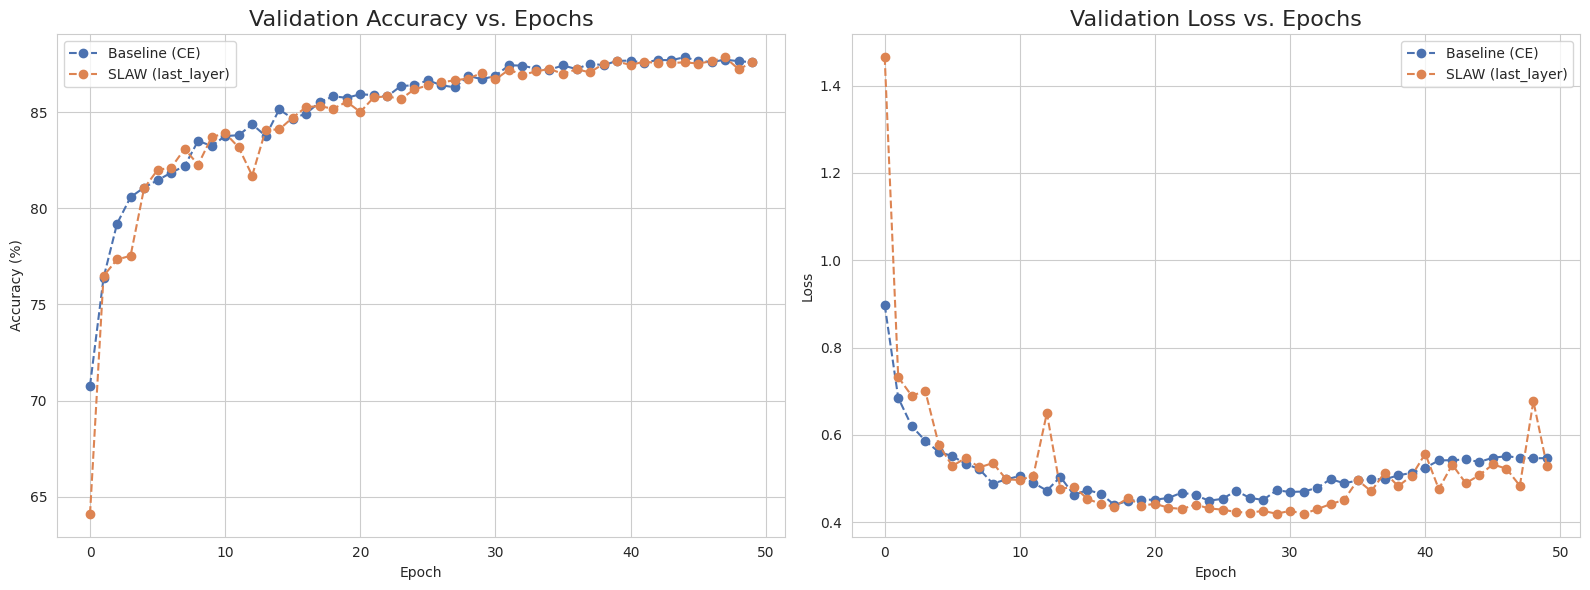

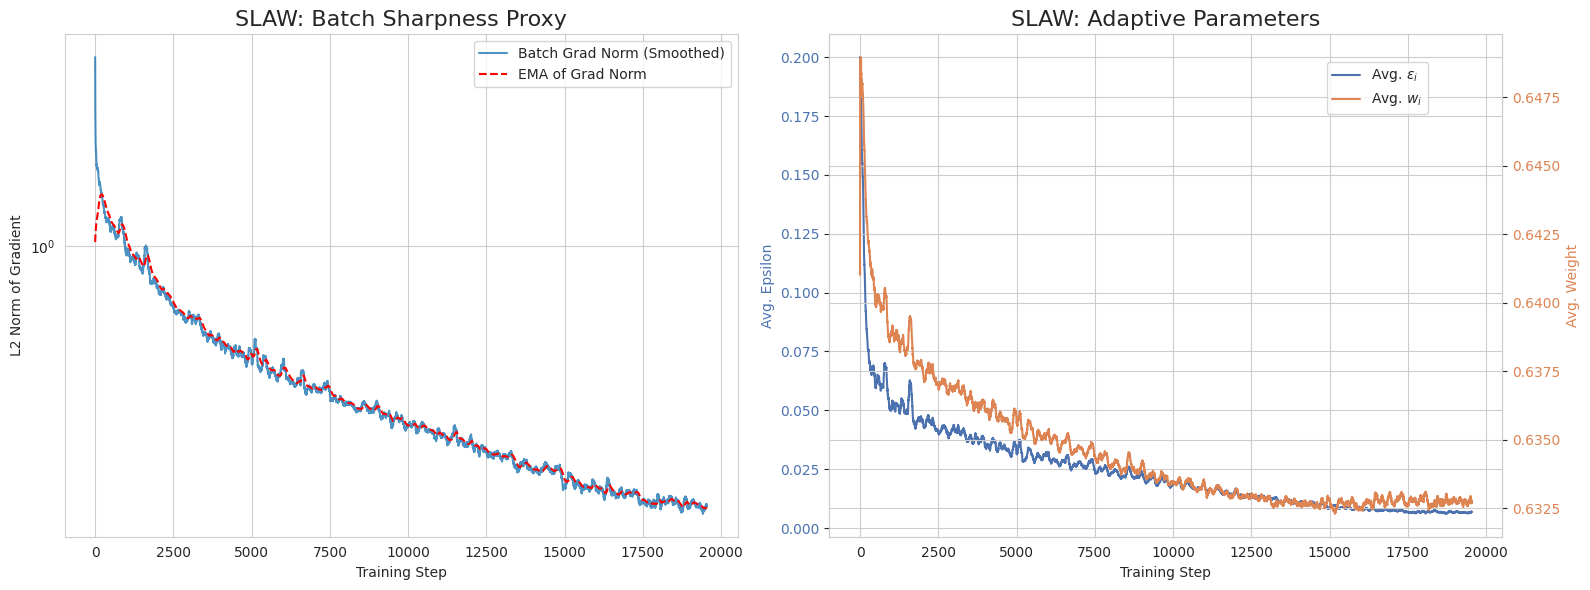

Analysis complete.


In [ ]:
# all the above code i used was in one cell now for clariy and easy understanding for readeers i organize them in different cells but for
# understanding and running i would recommend to clone the repo and use that code.
# its my expirement lab so may be you guyz dont get completely thanks for your understanding...

# folloing is the results of the the above expirement.. i have included the figure in the paper ...



# custom datset class for expirement 2 and 3

In [ ]:

import numpy as np
from torch.utils.data import Dataset

class NoisyCIFAR10(Dataset):
    """
    A wrapper for CIFAR-10 that introduces symmetric label noise.
    """
    def __init__(self, cifar_dataset, noise_rate=0.2, random_state=42):
        self.dataset = cifar_dataset
        self.num_classes = len(cifar_dataset.classes)
        self.noise_rate = noise_rate
        self.original_targets = np.array(cifar_dataset.targets)
        self.noisy_targets = self._create_noisy_labels(random_state)

        # replace the dataset's targets with our noisy ones
        self.dataset.targets = self.noisy_targets

        print(f"Created a NoisyCIFAR10 dataset with {noise_rate*100}% symmetric noise.")
        # verify a few samples
        correct_count = np.sum(self.original_targets == self.noisy_targets)
        print(f"Actual agreement with original labels: {correct_count / len(self.original_targets):.2%}")

    def _create_noisy_labels(self, random_state):
        rng = np.random.RandomState(random_state)
        noisy_targets = self.original_targets.copy()

        # determine which indices to corrupt
        num_samples = len(self.original_targets)
        num_to_corrupt = int(self.noise_rate * num_samples)
        indices_to_corrupt = rng.choice(num_samples, num_to_corrupt, replace=False)

        for idx in indices_to_corrupt:
            original_label = noisy_targets[idx]
            # choose a new label from any of the *other* classes
            potential_new_labels = [l for l in range(self.num_classes) if l != original_label]
            new_label = rng.choice(potential_new_labels)
            noisy_targets[idx] = new_label

        return list(noisy_targets)

    def __getitem__(self, index):
        # The __getitem__ from the original dataset will now return the noisy label
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)

# **Expirement-2 using noisy cifar 10 dataset**

## setup and imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
import pickle
import os

# for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# check for the presence of gpu for speed up trianing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# create directories for saving results
os.makedirs('results', exist_ok=True)
os.makedirs('plots', exist_ok=True)


## The SLAW

In [ ]:
class SLAW:
    """ SLAW (Version 3.2) - Uses retain_graph=True for the correct autograd handling. """
    def __init__(self, model, num_classes,
                 alpha=0.2, eps_min=0.0, eps_max=0.2, sharp_ema_decay=0.99,
                 tau=1.0, beta=1.0, gamma=0.7,
                 sharpness_scope='last_layer'):

        self.m = model
        self.K = num_classes
        self.alpha, self.eps_min, self.eps_max = alpha, eps_min, eps_max
        self.decay = sharp_ema_decay
        self.sharp_ema = 1.0
        self.tau, self.beta, self.gamma = tau, beta, gamma
        self.device = next(model.parameters()).device
        self.step_idx = 0

        self.sharpness_scope = sharpness_scope
        self._grad_params = self._get_params_for_sharpness()
        if not self._grad_params:
            print("Warning: SLAW could not find parameters. Defaulting to full model.")
            self.sharpness_scope = 'full'
            self._grad_params = [p for p in self.m.parameters() if p.requires_grad]

    def _get_params_for_sharpness(self):
        if self.sharpness_scope == 'last_layer':
            last_layer = None
            for module in reversed(list(self.m.modules())):
                if isinstance(module, (nn.Linear, nn.Conv2d)) and hasattr(module, 'weight') and module.weight.requires_grad:
                    last_layer = module
                    break
            if last_layer:
                print(f"SLAW: Using last layer ({type(last_layer).__name__}) for sharpness proxy.")
                return list(last_layer.parameters())
            else: return []
        else:
            print("SLAW: Using full model for sharpness proxy.")
            return [p for p in self.m.parameters() if p.requires_grad]

    @torch.no_grad()
    def _update_sharp_ema(self, s_batch_float):
        self.sharp_ema = self.decay * self.sharp_ema + (1 - self.decay) * s_batch_float

    @torch.no_grad()
    def _get_sals_targets(self, probs, y, s_batch_tensor):
        conf = probs.max(dim=1).values
        sharpness_scale = (s_batch_tensor / (self.sharp_ema + 1e-12)).clamp(min=0.1, max=10.0)
        eps_i = (self.alpha * sharpness_scale * (1.0 - conf)).clamp(self.eps_min, self.eps_max)

        B = y.size(0)
        off_target_fill = eps_i.unsqueeze(1) / (self.K - 1 + 1e-12)
        t = off_target_fill.expand(-1, self.K).clone()
        t.scatter_(1, y.unsqueeze(1), 1.0 - eps_i.unsqueeze(1))
        return t, eps_i

    def _get_sharpness_proxy(self, logits, y):
        with torch.enable_grad():
            ce_loss_for_grad = F.cross_entropy(logits, y, reduction='mean')
            grads = torch.autograd.grad(ce_loss_for_grad, self._grad_params, create_graph=False, retain_graph=True)
        s_batch = torch.sqrt(sum((g.detach()**2).sum() for g in grads) + 1e-12)
        return s_batch

    def __call__(self, logits, y):
        self.step_idx += 1

        s_batch_tensor = self._get_sharpness_proxy(logits, y)

        self._update_sharp_ema(s_batch_tensor.item())
        sals_targets, eps_i_stats = self._get_sals_targets(logits.softmax(dim=1).detach(), y, s_batch_tensor)

        log_probs = F.log_softmax(logits, dim=1)
        sals_per_sample = -(sals_targets * log_probs).sum(dim=1)

        with torch.no_grad():
            loss_vals = sals_per_sample.detach()
            mu, std = loss_vals.mean(), loss_vals.std() + 1e-8
            standardized_loss = (loss_vals - mu) / std
            weights = (torch.sigmoid(standardized_loss / self.tau).pow(self.beta) * self.gamma) + (1 - self.gamma)

        slaw_loss = (weights * sals_per_sample).mean()
        metrics = {'s_batch': s_batch_tensor.item(), 'sharp_ema': self.sharp_ema, 'eps_mean': eps_i_stats.mean().item(), 'weight_mean': weights.mean().item()}
        return slaw_loss, metrics

## Data loader and model definition.

In [ ]:
print("Preparing CIFAR-10 data...")
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# original trainset
trainset_clean = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# create the noisy version for the experiment
NOISE_LEVEL = 0.4  # Start with 20% then use 40%
trainset_noisy = NoisyCIFAR10(trainset_clean, noise_rate=NOISE_LEVEL)

# update  trainloader to use the noisy dataset
trainloader = torch.utils.data.DataLoader(trainset_noisy, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

def get_model():
    model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(device)

## Training and Evaluation Utilities

In [ ]:
class History:
    def __init__(self): self.history = {}
    def new_run(self, name): self.history[name] = {'epochs': [], 'steps': []}
    def add_epoch_log(self, name, log): self.history[name]['epochs'].append(log)
    def add_step_log(self, name, log): self.history[name]['steps'].append(log)
    def get_epoch_df(self, name): return pd.DataFrame(self.history[name]['epochs'])
    def get_step_df(self, name): return pd.DataFrame(self.history[name]['steps'])
    def save(self, fp):
        with open(fp, 'wb') as f: pickle.dump(self.history, f)
    def load(self, fp):
        with open(fp, 'rb') as f: self.history = pickle.load(f)

def train_one_epoch(model, dataloader, criterion, optimizer, run_name, history_tracker):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        slaw_metrics = {}
        if isinstance(criterion, SLAW):
            loss, slaw_metrics = criterion(outputs, targets)
        else:
            loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(targets).sum().item()
        total_samples += inputs.size(0)
        if slaw_metrics: history_tracker.add_step_log(run_name, slaw_metrics)
        progress_bar.set_postfix(loss=total_loss/total_samples, acc=100.*total_correct/total_samples)
    return total_loss / total_samples, 100. * total_correct / total_samples

def evaluate(model, dataloader):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_correct += predicted.eq(targets).sum().item()
            total_samples += inputs.size(0)
    return total_loss / total_samples, 100. * total_correct / total_samples

## Main Script

In [ ]:
N_EPOCHS = 50
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 5e-4

HISTORY_FILE = f'results/cifar10_noise_{int(NOISE_LEVEL*100)}_history.pkl'



experiment_configs = {
    f"Baseline (CE) on {int(NOISE_LEVEL*100)}% Noise": {},

    f"SLAW (last_layer) on {int(NOISE_LEVEL*100)}% Noise": {
        'gamma': 0.9,
        'alpha': 0.2, 'eps_max': 0.2, 'tau': 1.0, 'beta': 1.0,
        'sharpness_scope': 'last_layer'
    },

}

try:
    history = History()
    history.load(HISTORY_FILE)
    print(f"Loaded existing history from {HISTORY_FILE}")
except FileNotFoundError:
    history = History()
    print("No existing history found. Starting a new one.")

for run_name, config in experiment_configs.items():
    if run_name in history.history and history.get_epoch_df(run_name).shape[0] >= N_EPOCHS:
        print(f"--> Skipping '{run_name}' as it's already completed in the history file.")
        continue
    # ... (Rest of the loop is identical and will work correctly)
    print(f"\n{'='*20} Starting Run: {run_name} {'='*20}")
    set_seed(42)
    model = get_model()
    history.new_run(run_name)

    criterion = SLAW(model, 10, **config) if "SLAW" in run_name else nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

    best_val_acc = 0.0
    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, run_name, history)
        val_loss, val_acc = evaluate(model, testloader)
        scheduler.step()

        print(f"Epoch {epoch+1}/{N_EPOCHS} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        history.add_epoch_log(run_name, {'epoch': epoch, 'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc})

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_path = f"results/{run_name}_best_model.pth"
            torch.save(model.state_dict(), model_path)
            print(f"  -> New best model saved to {model_path} (Acc: {best_val_acc:.2f}%)")

    print(f"Finished run {run_name}. Best Validation Accuracy: {best_val_acc:.2f}%")

    history.save(HISTORY_FILE)
    print(f"History updated and saved to '{HISTORY_FILE}'")

print("\nAll experiments complete.")

## PLOTTING AND ANALYSIS

In [ ]:
print("\nGenerating plots from final history...")
sns.set_style("whitegrid")
palette = sns.color_palette("deep")

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
for i, run_name in enumerate(history.history.keys()):
    df = history.get_epoch_df(run_name)
    axs[0].plot(df['epoch'], df['val_acc'], label=f"{run_name}", marker='o', linestyle='--', color=palette[i])
    axs[1].plot(df['epoch'], df['val_loss'], label=f"{run_name}", marker='o', linestyle='--', color=palette[i])

axs[0].set_title("Validation Accuracy vs. Epochs", fontsize=16)
axs[0].set_xlabel("Epoch"); axs[0].set_ylabel("Accuracy (%)"); axs[0].legend(); axs[0].grid(True)
axs[1].set_title("Validation Loss vs. Epochs", fontsize=16)
axs[1].set_xlabel("Epoch"); axs[1].set_ylabel("Loss"); axs[1].legend(); axs[1].grid(True)
plt.tight_layout(); plt.savefig('plots/accuracy_loss_curves_v3.png', dpi=300); plt.show()

slaw_run_name = next((name for name in history.history.keys() if "SLAW" in name), None)
if slaw_run_name:
    slaw_step_df = history.get_step_df(slaw_run_name)
    if not slaw_step_df.empty:
        slaw_step_df_smooth = slaw_step_df.rolling(window=100, min_periods=1).mean()
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        axs[0].plot(slaw_step_df_smooth.index, slaw_step_df_smooth['s_batch'], label='Batch Grad Norm (Smoothed)', alpha=0.8)
        axs[0].plot(slaw_step_df_smooth.index, slaw_step_df_smooth['sharp_ema'], label='EMA of Grad Norm', linestyle='--', color='red')
        axs[0].set_title("SLAW: Batch Sharpness Proxy", fontsize=16)
        axs[0].set_xlabel("Training Step"); axs[0].set_ylabel("L2 Norm of Gradient"); axs[0].legend(); axs[0].grid(True); axs[0].set_yscale('log')
        ax2 = axs[1].twinx()
        p1, = axs[1].plot(slaw_step_df_smooth.index, slaw_step_df_smooth['eps_mean'], label='Avg. $\\epsilon_i$', color=palette[0])
        p2, = ax2.plot(slaw_step_df_smooth.index, slaw_step_df_smooth['weight_mean'], label='Avg. $w_i$', color=palette[1])
        axs[1].set_title("SLAW: Adaptive Parameters", fontsize=16); axs[1].set_xlabel("Training Step")
        axs[1].set_ylabel("Avg. Epsilon", color=palette[0]); ax2.set_ylabel("Avg. Weight", color=palette[1])
        axs[1].tick_params(axis='y', labelcolor=palette[0]); ax2.tick_params(axis='y', labelcolor=palette[1])
        fig.legend(handles=[p1, p2], loc='upper right', bbox_to_anchor=(0.9, 0.9))
        plt.tight_layout(); plt.savefig('plots/slaw_dynamics_v3.png', dpi=300); plt.show()

print("Analysis complete.")

Using device: cuda
Preparing CIFAR-10 data...


100%|██████████| 170M/170M [00:04<00:00, 42.5MB/s]


Created a NoisyCIFAR10 dataset with 40.0% symmetric noise.
Actual agreement with original labels: 60.00%
No existing history found. Starting a new one.

==================== Starting Run: Baseline (CE) on 40% Noise ====================
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 2.0326, Train Acc: 33.76% | Val Loss: 1.2849, Val Acc: 65.27%
  -> New best model saved to results/Baseline (CE) on 40% Noise_best_model.pth (Acc: 65.27%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.8889, Train Acc: 41.87% | Val Loss: 1.1594, Val Acc: 70.62%
  -> New best model saved to results/Baseline (CE) on 40% Noise_best_model.pth (Acc: 70.62%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 1.8593, Train Acc: 43.47% | Val Loss: 1.2030, Val Acc: 69.74%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 1.8396, Train Acc: 44.51% | Val Loss: 1.1293, Val Acc: 72.84%
  -> New best model saved to results/Baseline (CE) on 40% Noise_best_model.pth (Acc: 72.84%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 1.8034, Train Acc: 46.30% | Val Loss: 1.0808, Val Acc: 75.92%
  -> New best model saved to results/Baseline (CE) on 40% Noise_best_model.pth (Acc: 75.92%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 1.7934, Train Acc: 46.72% | Val Loss: 1.0886, Val Acc: 74.46%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 1.7800, Train Acc: 47.31% | Val Loss: 1.0526, Val Acc: 74.58%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 1.7669, Train Acc: 48.08% | Val Loss: 1.0465, Val Acc: 76.26%
  -> New best model saved to results/Baseline (CE) on 40% Noise_best_model.pth (Acc: 76.26%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 1.8049, Train Acc: 45.90% | Val Loss: 1.0976, Val Acc: 73.55%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 1.7673, Train Acc: 48.02% | Val Loss: 1.0451, Val Acc: 75.62%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 1.7497, Train Acc: 48.83% | Val Loss: 1.0192, Val Acc: 78.06%
  -> New best model saved to results/Baseline (CE) on 40% Noise_best_model.pth (Acc: 78.06%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 1.7345, Train Acc: 49.53% | Val Loss: 0.9861, Val Acc: 78.03%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 1.7278, Train Acc: 49.94% | Val Loss: 1.0305, Val Acc: 78.42%
  -> New best model saved to results/Baseline (CE) on 40% Noise_best_model.pth (Acc: 78.42%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 1.7244, Train Acc: 50.00% | Val Loss: 0.9573, Val Acc: 79.77%
  -> New best model saved to results/Baseline (CE) on 40% Noise_best_model.pth (Acc: 79.77%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 1.7033, Train Acc: 50.94% | Val Loss: 0.9825, Val Acc: 77.80%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 1.6915, Train Acc: 51.37% | Val Loss: 0.9465, Val Acc: 79.38%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 1.6809, Train Acc: 51.76% | Val Loss: 0.9472, Val Acc: 78.99%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 1.6714, Train Acc: 52.03% | Val Loss: 1.1024, Val Acc: 75.99%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 1.6651, Train Acc: 52.19% | Val Loss: 0.9385, Val Acc: 79.42%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 1.6546, Train Acc: 52.64% | Val Loss: 0.9388, Val Acc: 79.36%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 1.6395, Train Acc: 53.27% | Val Loss: 0.9644, Val Acc: 79.67%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 1.6261, Train Acc: 53.64% | Val Loss: 0.9848, Val Acc: 78.72%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 1.6170, Train Acc: 54.00% | Val Loss: 0.9270, Val Acc: 80.04%
  -> New best model saved to results/Baseline (CE) on 40% Noise_best_model.pth (Acc: 80.04%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 1.6059, Train Acc: 54.39% | Val Loss: 0.9231, Val Acc: 79.83%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 1.5893, Train Acc: 54.75% | Val Loss: 1.0101, Val Acc: 78.45%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 1.6034, Train Acc: 53.89% | Val Loss: 1.0522, Val Acc: 74.32%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 1.6174, Train Acc: 53.23% | Val Loss: 0.9392, Val Acc: 79.43%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 1.5661, Train Acc: 55.17% | Val Loss: 0.9548, Val Acc: 79.51%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 1.5437, Train Acc: 56.04% | Val Loss: 0.9482, Val Acc: 79.46%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 1.5272, Train Acc: 56.42% | Val Loss: 0.9450, Val Acc: 79.28%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 1.5111, Train Acc: 56.68% | Val Loss: 0.9339, Val Acc: 79.07%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 1.4919, Train Acc: 57.38% | Val Loss: 0.9823, Val Acc: 78.10%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 1.4758, Train Acc: 57.58% | Val Loss: 0.9738, Val Acc: 78.40%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 1.4593, Train Acc: 58.10% | Val Loss: 1.0305, Val Acc: 77.19%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 1.4433, Train Acc: 58.49% | Val Loss: 1.0272, Val Acc: 77.06%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 1.4283, Train Acc: 58.72% | Val Loss: 0.9799, Val Acc: 77.55%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 1.4117, Train Acc: 59.21% | Val Loss: 0.9870, Val Acc: 76.90%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 1.3912, Train Acc: 59.57% | Val Loss: 1.0654, Val Acc: 76.21%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 1.3790, Train Acc: 59.97% | Val Loss: 0.9968, Val Acc: 76.37%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 1.3616, Train Acc: 60.39% | Val Loss: 1.0134, Val Acc: 75.94%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 1.3523, Train Acc: 60.70% | Val Loss: 1.0522, Val Acc: 75.55%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 1.3382, Train Acc: 60.73% | Val Loss: 1.0699, Val Acc: 75.34%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 1.3276, Train Acc: 61.13% | Val Loss: 1.1258, Val Acc: 74.63%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 1.3241, Train Acc: 61.16% | Val Loss: 1.0776, Val Acc: 74.51%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 1.3162, Train Acc: 61.35% | Val Loss: 1.0724, Val Acc: 74.59%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 1.3071, Train Acc: 61.51% | Val Loss: 1.1901, Val Acc: 74.12%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 1.2999, Train Acc: 61.80% | Val Loss: 1.0806, Val Acc: 74.25%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 1.2975, Train Acc: 61.62% | Val Loss: 1.0751, Val Acc: 73.92%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 1.2951, Train Acc: 61.91% | Val Loss: 1.0888, Val Acc: 74.01%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 1.3002, Train Acc: 61.71% | Val Loss: 1.0910, Val Acc: 73.80%
Finished run Baseline (CE) on 40% Noise. Best Validation Accuracy: 80.04%
History updated and saved to 'results/cifar10_noise_40_history.pkl'

==================== Starting Run: SLAW (last_layer) on 40% Noise ====================
SLAW: Using last layer (Linear) for sharpness proxy.


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.2581, Train Acc: 28.86% | Val Loss: 1.7313, Val Acc: 61.57%
  -> New best model saved to results/SLAW (last_layer) on 40% Noise_best_model.pth (Acc: 61.57%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.2312, Train Acc: 38.85% | Val Loss: 1.6818, Val Acc: 62.26%
  -> New best model saved to results/SLAW (last_layer) on 40% Noise_best_model.pth (Acc: 62.26%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 1.2230, Train Acc: 40.76% | Val Loss: 1.6970, Val Acc: 62.68%
  -> New best model saved to results/SLAW (last_layer) on 40% Noise_best_model.pth (Acc: 62.68%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 1.2119, Train Acc: 42.99% | Val Loss: 1.5612, Val Acc: 70.06%
  -> New best model saved to results/SLAW (last_layer) on 40% Noise_best_model.pth (Acc: 70.06%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 1.2066, Train Acc: 43.92% | Val Loss: 1.5465, Val Acc: 72.35%
  -> New best model saved to results/SLAW (last_layer) on 40% Noise_best_model.pth (Acc: 72.35%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 1.2027, Train Acc: 44.77% | Val Loss: 1.5152, Val Acc: 72.72%
  -> New best model saved to results/SLAW (last_layer) on 40% Noise_best_model.pth (Acc: 72.72%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 1.1966, Train Acc: 45.65% | Val Loss: 1.4816, Val Acc: 73.27%
  -> New best model saved to results/SLAW (last_layer) on 40% Noise_best_model.pth (Acc: 73.27%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 1.1912, Train Acc: 46.49% | Val Loss: 1.4866, Val Acc: 73.62%
  -> New best model saved to results/SLAW (last_layer) on 40% Noise_best_model.pth (Acc: 73.62%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 1.1866, Train Acc: 47.19% | Val Loss: 1.4762, Val Acc: 75.56%
  -> New best model saved to results/SLAW (last_layer) on 40% Noise_best_model.pth (Acc: 75.56%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 1.1842, Train Acc: 47.60% | Val Loss: 1.4371, Val Acc: 75.34%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 1.1818, Train Acc: 47.83% | Val Loss: 1.4748, Val Acc: 75.45%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 1.1813, Train Acc: 47.80% | Val Loss: 1.4166, Val Acc: 77.44%
  -> New best model saved to results/SLAW (last_layer) on 40% Noise_best_model.pth (Acc: 77.44%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 1.1765, Train Acc: 48.74% | Val Loss: 1.4081, Val Acc: 77.62%
  -> New best model saved to results/SLAW (last_layer) on 40% Noise_best_model.pth (Acc: 77.62%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 1.1738, Train Acc: 48.73% | Val Loss: 1.4098, Val Acc: 75.95%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 1.1711, Train Acc: 49.08% | Val Loss: 1.4087, Val Acc: 76.01%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 1.1796, Train Acc: 47.47% | Val Loss: 1.3809, Val Acc: 77.54%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 1.1660, Train Acc: 49.52% | Val Loss: 1.3572, Val Acc: 78.40%
  -> New best model saved to results/SLAW (last_layer) on 40% Noise_best_model.pth (Acc: 78.40%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 1.1587, Train Acc: 50.37% | Val Loss: 1.3442, Val Acc: 78.35%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 1.1553, Train Acc: 50.69% | Val Loss: 1.3315, Val Acc: 78.84%
  -> New best model saved to results/SLAW (last_layer) on 40% Noise_best_model.pth (Acc: 78.84%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 1.1520, Train Acc: 51.05% | Val Loss: 1.3312, Val Acc: 79.23%
  -> New best model saved to results/SLAW (last_layer) on 40% Noise_best_model.pth (Acc: 79.23%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 1.1486, Train Acc: 51.52% | Val Loss: 1.3646, Val Acc: 77.47%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 1.1456, Train Acc: 51.51% | Val Loss: 1.3400, Val Acc: 79.72%
  -> New best model saved to results/SLAW (last_layer) on 40% Noise_best_model.pth (Acc: 79.72%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 1.1437, Train Acc: 51.76% | Val Loss: 1.3205, Val Acc: 79.19%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 1.1374, Train Acc: 52.17% | Val Loss: 1.3161, Val Acc: 78.99%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 1.1308, Train Acc: 52.75% | Val Loss: 1.3048, Val Acc: 78.18%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 1.1274, Train Acc: 52.79% | Val Loss: 1.2724, Val Acc: 79.53%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 1.1197, Train Acc: 53.36% | Val Loss: 1.2708, Val Acc: 79.69%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 1.1134, Train Acc: 53.81% | Val Loss: 1.2988, Val Acc: 78.55%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 1.1103, Train Acc: 53.73% | Val Loss: 1.2851, Val Acc: 79.24%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 1.0988, Train Acc: 54.54% | Val Loss: 1.2750, Val Acc: 78.61%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 1.0924, Train Acc: 54.78% | Val Loss: 1.2580, Val Acc: 78.34%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 1.0845, Train Acc: 55.39% | Val Loss: 1.2609, Val Acc: 78.64%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 1.0744, Train Acc: 55.96% | Val Loss: 1.2294, Val Acc: 78.09%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 1.0647, Train Acc: 56.33% | Val Loss: 1.2555, Val Acc: 77.05%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 1.0573, Train Acc: 56.52% | Val Loss: 1.2342, Val Acc: 77.41%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 1.0467, Train Acc: 57.25% | Val Loss: 1.2332, Val Acc: 77.09%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 1.0411, Train Acc: 57.42% | Val Loss: 1.2311, Val Acc: 76.92%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 1.0323, Train Acc: 57.83% | Val Loss: 1.2177, Val Acc: 76.79%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 1.0239, Train Acc: 58.20% | Val Loss: 1.2212, Val Acc: 75.88%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 1.0158, Train Acc: 58.71% | Val Loss: 1.2013, Val Acc: 75.54%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 1.0084, Train Acc: 59.07% | Val Loss: 1.2078, Val Acc: 75.53%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 1.0026, Train Acc: 59.32% | Val Loss: 1.2093, Val Acc: 75.52%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.9950, Train Acc: 59.56% | Val Loss: 1.2116, Val Acc: 75.05%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.9942, Train Acc: 59.46% | Val Loss: 1.2167, Val Acc: 74.40%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.9870, Train Acc: 60.03% | Val Loss: 1.1997, Val Acc: 74.69%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.9853, Train Acc: 60.09% | Val Loss: 1.1976, Val Acc: 74.56%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.9804, Train Acc: 60.22% | Val Loss: 1.1930, Val Acc: 74.84%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.9831, Train Acc: 60.09% | Val Loss: 1.2004, Val Acc: 74.48%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.9798, Train Acc: 60.23% | Val Loss: 1.2014, Val Acc: 74.43%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.9792, Train Acc: 60.25% | Val Loss: 1.2076, Val Acc: 74.13%
Finished run SLAW (last_layer) on 40% Noise. Best Validation Accuracy: 79.72%
History updated and saved to 'results/cifar10_noise_40_history.pkl'

All experiments complete.

Generating plots from final history...


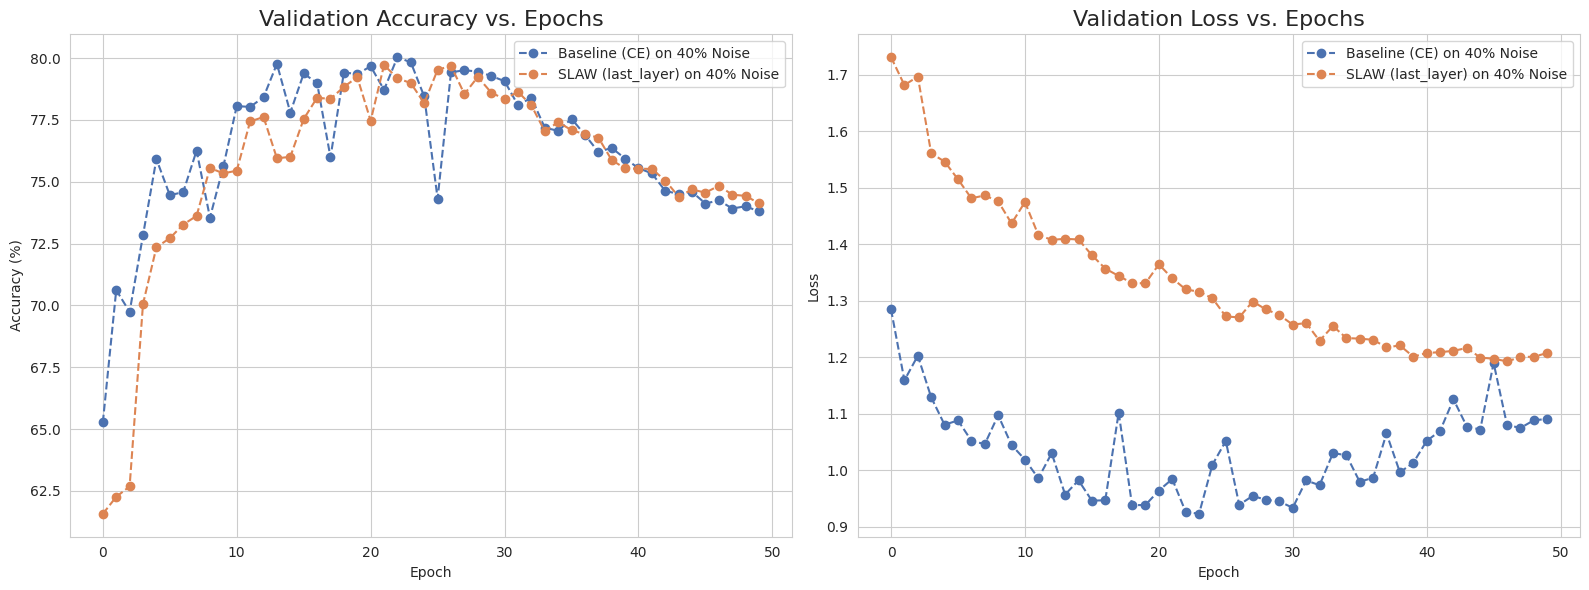

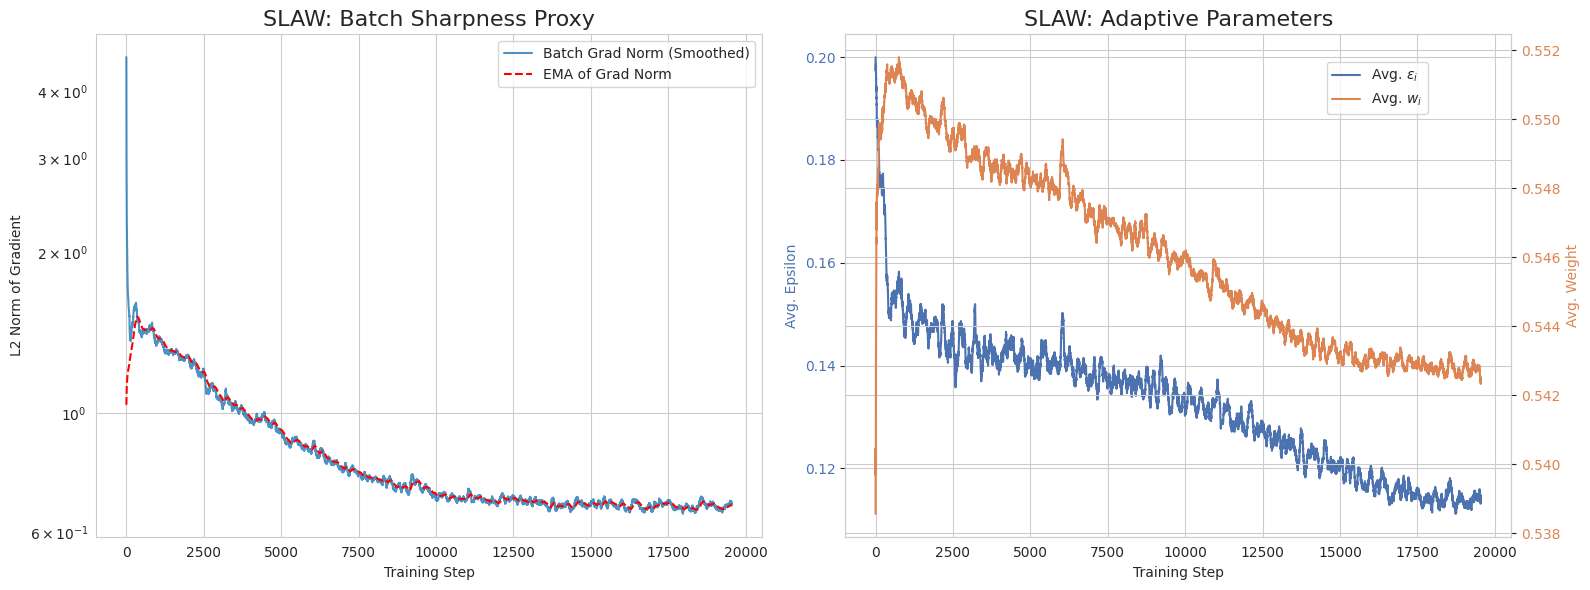

Analysis complete.


In [ ]:


# same as above using the clone version is recomended for easy manupulation and reproducibility


## CALIBRATION ANALYSIS

the output of this cell is for 40% noise expirement. you can also use this cell for calculating the 20% noise model ece

In [ ]:


@torch.no_grad()
def calculate_ece(model, dataloader, n_bins=15, device='cuda'):
    """
    Calculates the Expected
    Calibration Error of a model.
    """
    model.eval()

    all_confidences = []
    all_correct = []

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        probs = F.softmax(logits, dim=1)

        confidences, predictions = torch.max(probs, dim=1)
        correct = predictions.eq(targets)

        all_confidences.append(confidences.cpu())
        all_correct.append(correct.cpu())

    all_confidences = torch.cat(all_confidences)
    all_correct = torch.cat(all_correct)

    # create bins of equal width
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # find predictions within the confidence bin
        in_bin = (all_confidences > bin_lower) & (all_confidences <= bin_upper)
        prop_in_bin = in_bin.float().mean()

        if prop_in_bin > 0:
            accuracy_in_bin = all_correct[in_bin].float().mean()
            avg_confidence_in_bin = all_confidences[in_bin].mean()

            # add to ECE
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return ece.item()


print("\n" + "="*20 + " Final Model Evaluation " + "="*20)


try:
    history
except NameError:
    history = History()
    history.load(HISTORY_FILE)
    print(f"Loaded history from {HISTORY_FILE} for final analysis.")

for run_name in experiment_configs.keys():
    print(f"\nAnalyzing run: '{run_name}'")

    #load the best model
    model = get_model()
    model_path = f"results/{run_name}_best_model.pth"

    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except FileNotFoundError:
        print(f"  -> Model file not found at {model_path}. Skipping.")
        continue


    df = history.get_epoch_df(run_name)
    best_acc = df['val_acc'].max()

    # calculate ece on test set
    ece_score = calculate_ece(model, testloader, device=device)

    print(f"  -> Best Validation Accuracy: {best_acc:.2f}%")
    print(f"  -> Expected Calibration Error (ECE): {ece_score:.4f}")


==================== Final Model Evaluation ====================

Analyzing run: 'Baseline (CE) on 40% Noise'
  -> Best Validation Accuracy: 80.04%
  -> Expected Calibration Error (ECE): 0.2699

Analyzing run: 'SLAW (last_layer) on 40% Noise'
  -> Best Validation Accuracy: 79.72%
  -> Expected Calibration Error (ECE): 0.4864


## RELIABILITY DIAGRAMS


==================== Reliability Diagram Analysis (40% Noise) ====================

Generating diagram for: 'Baseline (CE) on 40% Noise'

Generating diagram for: 'SLAW (last_layer) on 40% Noise'


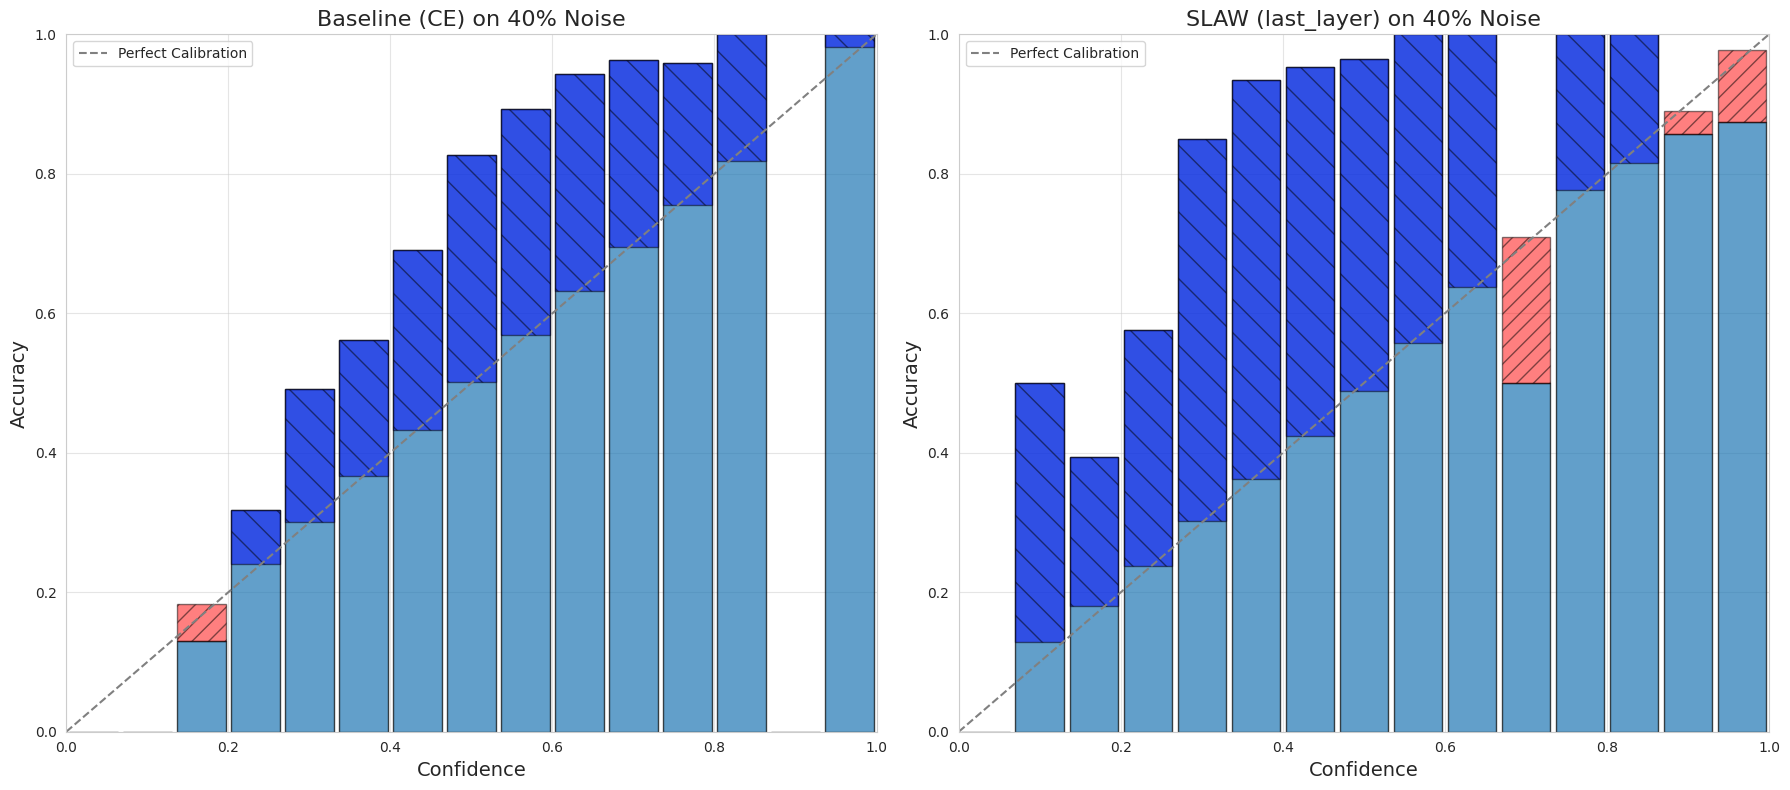

In [ ]:


@torch.no_grad()
def get_reliability_data(model, dataloader, n_bins=15, device='cuda'):
    """
    Gathers data required for a reliability diagram.
    """
    model.eval()
    all_confidences, all_correct = [], []

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        probs = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(probs, dim=1)
        correct = predictions.eq(targets)
        all_confidences.append(confidences.cpu())
        all_correct.append(correct.cpu())

    all_confidences = torch.cat(all_confidences)
    all_correct = torch.cat(all_correct)

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers, bin_uppers = bin_boundaries[:-1], bin_boundaries[1:]

    bin_accuracies, bin_confidences, bin_proportions = [], [], []

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (all_confidences > bin_lower) & (all_confidences <= bin_upper)
        prop_in_bin = in_bin.float().mean()
        bin_proportions.append(prop_in_bin.item())

        if prop_in_bin > 0:
            accuracy_in_bin = all_correct[in_bin].float().mean()
            avg_confidence_in_bin = all_confidences[in_bin].mean()
            bin_accuracies.append(accuracy_in_bin.item())
            bin_confidences.append(avg_confidence_in_bin.item())
        else:
            bin_accuracies.append(0)
            bin_confidences.append(0)

    return bin_accuracies, bin_confidences, bin_proportions


def plot_reliability_diagram(ax, bin_accuracies, bin_confidences, bin_proportions, title):
    """
    Plots a reliability diagram on a given matplotlib axis.
    """
    n_bins = len(bin_accuracies)
    bin_width = 1.0 / n_bins

    positions = np.linspace(0.0 + bin_width / 2, 1.0 - bin_width / 2, n_bins)

    bar_plot = ax.bar(positions, bin_accuracies, width=bin_width * 0.9, edgecolor="black", alpha=0.7)

    for i, (conf, acc, prop) in enumerate(zip(bin_confidences, bin_accuracies, bin_proportions)):
        if prop > 0:
            if acc < conf: # Over-confident
                ax.bar(positions[i], conf - acc, bottom=acc, width=bin_width * 0.9, color='red', alpha=0.5, edgecolor="black", hatch='//')
            else: # Under-confident
                # Blue bar for the gap
                ax.bar(positions[i], acc - conf, bottom=conf, width=bin_width * 0.9, color='blue', alpha=0.5, edgecolor="black", hatch='\\')


    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Confidence", fontsize=14)
    ax.set_ylabel("Accuracy", fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.grid(True, linestyle='-', alpha=0.5)
    ax.legend()


# --- Main Analysis Loop for 40% Noise Experiment ---
print("\n" + "="*20 + " Reliability Diagram Analysis (40% Noise) " + "="*20)

NOISE_LEVEL = 0.4
HISTORY_FILE = f'results/cifar10_noise_{int(NOISE_LEVEL*100)}_history.pkl'

experiment_configs = {
    f"Baseline (CE) on {int(NOISE_LEVEL*100)}% Noise": {},
    f"SLAW (last_layer) on {int(NOISE_LEVEL*100)}% Noise": {}
}

fig, axs = plt.subplots(1, 2, figsize=(18, 8))

for i, run_name in enumerate(experiment_configs.keys()):
    print(f"\nGenerating diagram for: '{run_name}'")

    model = get_model()
    model_path = f"results/{run_name}_best_model.pth"

    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except FileNotFoundError:
        print(f"  -> Model file not found at {model_path}. Skipping.")
        continue

    bin_accs, bin_confs, bin_props = get_reliability_data(model, testloader, device=device)

    plot_reliability_diagram(axs[i], bin_accs, bin_confs, bin_props, title=run_name)

plt.tight_layout()
plt.savefig(f'plots/reliability_diagram_noise_{int(NOISE_LEVEL*100)}.png', dpi=300)
plt.show()

# Ablation study Expirement

setup and imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
import pickle
import os


def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


os.makedirs('results', exist_ok=True)
os.makedirs('plots', exist_ok=True)

## The SLAW

In [ ]:
class SLAW:
    """ SLAW (Version 4 - Ablation Ready) """
    def __init__(self, model, num_classes,
                 alpha=0.2, eps_min=0.0, eps_max=0.2, sharp_ema_decay=0.99,
                 tau=1.0, beta=1.0, gamma=0.7,
                 sharpness_scope='last_layer',

                 use_sals=True, use_law=True):

        self.m = model
        self.K = num_classes
        self.alpha, self.eps_min, self.eps_max = alpha, eps_min, eps_max
        self.decay = sharp_ema_decay
        self.sharp_ema = 1.0
        self.tau, self.beta, self.gamma = tau, beta, gamma
        self.device = next(model.parameters()).device
        self.step_idx = 0

        self.sharpness_scope = sharpness_scope
        self._grad_params = self._get_params_for_sharpness()


        self.use_sals = use_sals
        self.use_law = use_law

        if self.use_sals and not self._grad_params:
             print("Warning: SLAW could not find params for SALS. Disabling.")
             self.use_sals = False

    def _get_params_for_sharpness(self):
        if self.sharpness_scope == 'last_layer':
            last_layer = None
            for module in reversed(list(self.m.modules())):
                if isinstance(module, (nn.Linear, nn.Conv2d)) and hasattr(module, 'weight') and module.weight.requires_grad:
                    last_layer = module
                    break
            if last_layer:
                print(f"SLAW: Using last layer ({type(last_layer).__name__}) for sharpness proxy.")
                return list(last_layer.parameters())
            else: return []
        else:
            print("SLAW: Using full model for sharpness proxy.")
            return [p for p in self.m.parameters() if p.requires_grad]

    @torch.no_grad()
    def _update_sharp_ema(self, s_batch_float):
      self.sharp_ema = self.decay * self.sharp_ema + (1 - self.decay) * s_batch_float

    @torch.no_grad()
    def _get_sals_targets(self, probs, y, s_batch_tensor):
        conf = probs.max(dim=1).values
        sharpness_scale = (s_batch_tensor / (self.sharp_ema + 1e-12)).clamp(min=0.1, max=10.0)
        eps_i = (self.alpha * sharpness_scale * (1.0 - conf)).clamp(self.eps_min, self.eps_max)
        B = y.size(0)
        off_target_fill = eps_i.unsqueeze(1) / (self.K - 1 + 1e-12)
        t = off_target_fill.expand(-1, self.K).clone()
        t.scatter_(1, y.unsqueeze(1), 1.0 - eps_i.unsqueeze(1))
        return t, eps_i

    def _get_sharpness_proxy(self, logits, y):
        with torch.enable_grad():
            ce_loss_for_grad = F.cross_entropy(logits, y, reduction='mean')
            grads = torch.autograd.grad(ce_loss_for_grad, self._grad_params, create_graph=False, retain_graph=True)
        s_batch = torch.sqrt(sum((g.detach()**2).sum() for g in grads) + 1e-12)
        return s_batch


    def __call__(self, logits, y):
        self.step_idx += 1
        metrics = {}



        # calculate the base per-sample loss
        if self.use_sals:
            s_batch_tensor = self._get_sharpness_proxy(logits, y)
            self._update_sharp_ema(s_batch_tensor.item())
            sals_targets, eps_i_stats = self._get_sals_targets(logits.softmax(dim=1).detach(), y, s_batch_tensor)
            log_probs = F.log_softmax(logits, dim=1)
            per_sample_loss = -(sals_targets * log_probs).sum(dim=1)
            metrics.update({'s_batch': s_batch_tensor.item(), 'sharp_ema': self.sharp_ema, 'eps_mean': eps_i_stats.mean().item()})
        else:
            # for LAW-only or CE, the base loss is standard Cross-Entropy
            per_sample_loss = F.cross_entropy(logits, y, reduction='none')

        #  calculate the final batch loss
        if self.use_law:
            with torch.no_grad():
                loss_vals = per_sample_loss.detach()
                mu, std = loss_vals.mean(), loss_vals.std() + 1e-8
                standardized_loss = (loss_vals - mu) / std
                weights = (torch.sigmoid(standardized_loss / self.tau).pow(self.beta) * self.gamma) + (1 - self.gamma)

            final_loss = (weights * per_sample_loss).mean()
            metrics.update({'weight_mean': weights.mean().item()})
        else:
            # for SALS-only or CE, the final loss is a simple mean
            final_loss = per_sample_loss.mean()

        return final_loss, metrics


## data loading and model defintion

In [ ]:
print("Preparing CIFAR-10 data...")
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# original trainset
trainset_clean = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# create the noisy version for the experiment
NOISE_LEVEL = 0.2  # Start with 20% then use 40%
trainset_noisy = NoisyCIFAR10(trainset_clean, noise_rate=NOISE_LEVEL)

# update  trainloader to use the noisy dataset
trainloader = torch.utils.data.DataLoader(trainset_noisy, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

def get_model():
    model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(device)


## Training And evaluation MAtrixes

In [ ]:
class History:
    def __init__(self): self.history = {}
    def new_run(self, name): self.history[name] = {'epochs': [], 'steps': []}
    def add_epoch_log(self, name, log): self.history[name]['epochs'].append(log)
    def add_step_log(self, name, log): self.history[name]['steps'].append(log)
    def get_epoch_df(self, name): return pd.DataFrame(self.history[name]['epochs'])
    def get_step_df(self, name): return pd.DataFrame(self.history[name]['steps'])
    def save(self, fp):
        with open(fp, 'wb') as f: pickle.dump(self.history, f)
    def load(self, fp):
        with open(fp, 'rb') as f: self.history = pickle.load(f)

def train_one_epoch(model, dataloader, criterion, optimizer, run_name, history_tracker):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        slaw_metrics = {}
        if isinstance(criterion, SLAW):
            loss, slaw_metrics = criterion(outputs, targets)
        else:
            loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(targets).sum().item()
        total_samples += inputs.size(0)
        if slaw_metrics: history_tracker.add_step_log(run_name, slaw_metrics)
        progress_bar.set_postfix(loss=total_loss/total_samples, acc=100.*total_correct/total_samples)
    return total_loss / total_samples, 100. * total_correct / total_samples

def evaluate(model, dataloader):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_correct += predicted.eq(targets).sum().item()
            total_samples += inputs.size(0)
    return total_loss / total_samples, 100. * total_correct / total_samples

## main script

In [ ]:
N_EPOCHS = 50
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 5e-4

HISTORY_FILE = f'results/cifar10_noise_{int(NOISE_LEVEL*100)}_history.pkl'



# this dictionary now defines our entire ablation study
experiment_configs = {
    # you can comment out runs you've already completed if their history is saved
    f"Baseline (CE) on {int(NOISE_LEVEL*100)}% Noise": {
        'use_sals': False, 'use_law': False
    },
    f"SALS-only on {int(NOISE_LEVEL*100)}% Noise": {
        'use_sals': True, 'use_law': False, 'gamma': 0.9 # Pass gamma just in case, won't be used
    },
    f"LAW-only on {int(NOISE_LEVEL*100)}% Noise": {
        'use_sals': False, 'use_law': True, 'gamma': 0.9
    },
    f"SLAW (Full) on {int(NOISE_LEVEL*100)}% Noise": {
        'use_sals': True, 'use_law': True, 'gamma': 0.9
    }
}

try:
    history = History()
    history.load(HISTORY_FILE)
    print(f"Loaded existing history from {HISTORY_FILE}")
except FileNotFoundError:
    history = History()
    print("No existing history found. Starting a new one.")

for run_name, config in experiment_configs.items():
    if run_name in history.history and history.get_epoch_df(run_name).shape[0] >= N_EPOCHS:
        print(f"--> Skipping '{run_name}' as it's already completed in the history file.")
        continue
    print(f"\n{'='*20} Starting Run: {run_name} {'='*20}")
    set_seed(42)
    model = get_model()
    history.new_run(run_name)


    print(f"  -> Config: use_sals={config.get('use_sals', True)}, use_law={config.get('use_law', True)}")
    if "Baseline (CE)" in run_name:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = SLAW(model, 10, **config)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

    best_val_acc = 0.0
    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, run_name, history)
        val_loss, val_acc = evaluate(model, testloader)
        scheduler.step()

        print(f"Epoch {epoch+1}/{N_EPOCHS} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        history.add_epoch_log(run_name, {'epoch': epoch, 'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc})

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_path = f"results/{run_name}_best_model.pth"
            torch.save(model.state_dict(), model_path)
            print(f"  -> New best model saved to {model_path} (Acc: {best_val_acc:.2f}%)")

    print(f"Finished run {run_name}. Best Validation Accuracy: {best_val_acc:.2f}%")

    history.save(HISTORY_FILE)
    print(f"History updated and saved to '{HISTORY_FILE}'")

print("\nAll experiments complete.")


## plotting and analysis

In [ ]:
print("\nGenerating plots from final history...")
sns.set_style("whitegrid")
palette = sns.color_palette("deep")

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
for i, run_name in enumerate(history.history.keys()):
    df = history.get_epoch_df(run_name)
    axs[0].plot(df['epoch'], df['val_acc'], label=f"{run_name}", marker='o', linestyle='--', color=palette[i])
    axs[1].plot(df['epoch'], df['val_loss'], label=f"{run_name}", marker='o', linestyle='--', color=palette[i])

axs[0].set_title("Validation Accuracy vs. Epochs", fontsize=16)
axs[0].set_xlabel("Epoch"); axs[0].set_ylabel("Accuracy (%)"); axs[0].legend(); axs[0].grid(True)
axs[1].set_title("Validation Loss vs. Epochs", fontsize=16)
axs[1].set_xlabel("Epoch"); axs[1].set_ylabel("Loss"); axs[1].legend(); axs[1].grid(True)
plt.tight_layout(); plt.savefig('plots/accuracy_loss_curves_v3.png', dpi=300); plt.show()

slaw_run_name = next((name for name in history.history.keys() if "SLAW" in name), None)
if slaw_run_name:
    slaw_step_df = history.get_step_df(slaw_run_name)
    if not slaw_step_df.empty:
        slaw_step_df_smooth = slaw_step_df.rolling(window=100, min_periods=1).mean()
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        axs[0].plot(slaw_step_df_smooth.index, slaw_step_df_smooth['s_batch'], label='Batch Grad Norm (Smoothed)', alpha=0.8)
        axs[0].plot(slaw_step_df_smooth.index, slaw_step_df_smooth['sharp_ema'], label='EMA of Grad Norm', linestyle='--', color='red')
        axs[0].set_title("SLAW: Batch Sharpness Proxy", fontsize=16)
        axs[0].set_xlabel("Training Step"); axs[0].set_ylabel("L2 Norm of Gradient"); axs[0].legend(); axs[0].grid(True); axs[0].set_yscale('log')
        ax2 = axs[1].twinx()
        p1, = axs[1].plot(slaw_step_df_smooth.index, slaw_step_df_smooth['eps_mean'], label='Avg. $\\epsilon_i$', color=palette[0])
        p2, = ax2.plot(slaw_step_df_smooth.index, slaw_step_df_smooth['weight_mean'], label='Avg. $w_i$', color=palette[1])
        axs[1].set_title("SLAW: Adaptive Parameters", fontsize=16); axs[1].set_xlabel("Training Step")
        axs[1].set_ylabel("Avg. Epsilon", color=palette[0]); ax2.set_ylabel("Avg. Weight", color=palette[1])
        axs[1].tick_params(axis='y', labelcolor=palette[0]); ax2.tick_params(axis='y', labelcolor=palette[1])
        fig.legend(handles=[p1, p2], loc='upper right', bbox_to_anchor=(0.9, 0.9))
        plt.tight_layout(); plt.savefig('plots/slaw_dynamics_v3.png', dpi=300); plt.show()

print("Analysis complete.")

Using device: cuda
Preparing CIFAR-10 data...


100%|██████████| 170M/170M [00:03<00:00, 43.2MB/s]


Created a NoisyCIFAR10 dataset with 20.0% symmetric noise.
Actual agreement with original labels: 80.00%
No existing history found. Starting a new one.

==================== Starting Run: Baseline (CE) on 20% Noise ====================
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


  -> Config: use_sals=False, use_law=False


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.6450, Train Acc: 49.15% | Val Loss: 1.0619, Val Acc: 67.36%
  -> New best model saved to results/Baseline (CE) on 20% Noise_best_model.pth (Acc: 67.36%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.4662, Train Acc: 56.93% | Val Loss: 0.9813, Val Acc: 70.55%
  -> New best model saved to results/Baseline (CE) on 20% Noise_best_model.pth (Acc: 70.55%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 1.4028, Train Acc: 59.58% | Val Loss: 0.8656, Val Acc: 75.89%
  -> New best model saved to results/Baseline (CE) on 20% Noise_best_model.pth (Acc: 75.89%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 1.3552, Train Acc: 61.74% | Val Loss: 0.8508, Val Acc: 76.21%
  -> New best model saved to results/Baseline (CE) on 20% Noise_best_model.pth (Acc: 76.21%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 1.3683, Train Acc: 61.06% | Val Loss: 0.8978, Val Acc: 74.84%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 1.3452, Train Acc: 61.99% | Val Loss: 0.8249, Val Acc: 76.50%
  -> New best model saved to results/Baseline (CE) on 20% Noise_best_model.pth (Acc: 76.50%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 1.2984, Train Acc: 64.02% | Val Loss: 0.7322, Val Acc: 79.40%
  -> New best model saved to results/Baseline (CE) on 20% Noise_best_model.pth (Acc: 79.40%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 1.2648, Train Acc: 65.45% | Val Loss: 0.7708, Val Acc: 78.53%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 1.2552, Train Acc: 65.78% | Val Loss: 0.7245, Val Acc: 80.53%
  -> New best model saved to results/Baseline (CE) on 20% Noise_best_model.pth (Acc: 80.53%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 1.2378, Train Acc: 66.59% | Val Loss: 0.7166, Val Acc: 79.47%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 1.2244, Train Acc: 66.99% | Val Loss: 0.7743, Val Acc: 80.07%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 1.2097, Train Acc: 67.64% | Val Loss: 0.6918, Val Acc: 80.83%
  -> New best model saved to results/Baseline (CE) on 20% Noise_best_model.pth (Acc: 80.83%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 1.2008, Train Acc: 67.88% | Val Loss: 0.7817, Val Acc: 80.45%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 1.1840, Train Acc: 68.37% | Val Loss: 0.7115, Val Acc: 80.33%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 1.1895, Train Acc: 68.04% | Val Loss: 0.6983, Val Acc: 81.29%
  -> New best model saved to results/Baseline (CE) on 20% Noise_best_model.pth (Acc: 81.29%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 1.1619, Train Acc: 69.09% | Val Loss: 0.7049, Val Acc: 80.78%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 1.1603, Train Acc: 69.25% | Val Loss: 0.6763, Val Acc: 82.21%
  -> New best model saved to results/Baseline (CE) on 20% Noise_best_model.pth (Acc: 82.21%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 1.1339, Train Acc: 70.15% | Val Loss: 0.6403, Val Acc: 82.55%
  -> New best model saved to results/Baseline (CE) on 20% Noise_best_model.pth (Acc: 82.55%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 1.1306, Train Acc: 70.28% | Val Loss: 0.6501, Val Acc: 82.81%
  -> New best model saved to results/Baseline (CE) on 20% Noise_best_model.pth (Acc: 82.81%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 1.1139, Train Acc: 70.70% | Val Loss: 0.6954, Val Acc: 81.30%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 1.1048, Train Acc: 71.08% | Val Loss: 0.6799, Val Acc: 82.01%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 1.1103, Train Acc: 70.82% | Val Loss: 0.6798, Val Acc: 82.44%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 1.0827, Train Acc: 71.59% | Val Loss: 0.6516, Val Acc: 83.29%
  -> New best model saved to results/Baseline (CE) on 20% Noise_best_model.pth (Acc: 83.29%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 1.0547, Train Acc: 72.60% | Val Loss: 0.6340, Val Acc: 82.90%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 1.0405, Train Acc: 72.94% | Val Loss: 0.6430, Val Acc: 83.30%
  -> New best model saved to results/Baseline (CE) on 20% Noise_best_model.pth (Acc: 83.30%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 1.0242, Train Acc: 73.44% | Val Loss: 0.6659, Val Acc: 81.63%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 1.0190, Train Acc: 73.37% | Val Loss: 0.6630, Val Acc: 82.89%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.9994, Train Acc: 73.95% | Val Loss: 0.6478, Val Acc: 83.11%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.9963, Train Acc: 74.01% | Val Loss: 0.6487, Val Acc: 82.96%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.9651, Train Acc: 74.72% | Val Loss: 0.6768, Val Acc: 82.33%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.9449, Train Acc: 74.99% | Val Loss: 0.6710, Val Acc: 82.58%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.9329, Train Acc: 75.30% | Val Loss: 0.7048, Val Acc: 81.77%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.9091, Train Acc: 76.10% | Val Loss: 0.6768, Val Acc: 82.17%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.9019, Train Acc: 75.99% | Val Loss: 0.7036, Val Acc: 81.31%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.8845, Train Acc: 76.38% | Val Loss: 0.6967, Val Acc: 81.89%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.8592, Train Acc: 77.09% | Val Loss: 0.6929, Val Acc: 82.24%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.8426, Train Acc: 77.22% | Val Loss: 0.7070, Val Acc: 81.80%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.8241, Train Acc: 77.63% | Val Loss: 0.7340, Val Acc: 81.22%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.8078, Train Acc: 78.11% | Val Loss: 0.7456, Val Acc: 81.33%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.7886, Train Acc: 78.46% | Val Loss: 0.7573, Val Acc: 80.97%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.7764, Train Acc: 78.75% | Val Loss: 0.7526, Val Acc: 80.91%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.7608, Train Acc: 79.13% | Val Loss: 0.7965, Val Acc: 80.74%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.7492, Train Acc: 79.40% | Val Loss: 0.7739, Val Acc: 80.90%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.7418, Train Acc: 79.47% | Val Loss: 0.7910, Val Acc: 80.50%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.7349, Train Acc: 79.62% | Val Loss: 0.7788, Val Acc: 80.93%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.7264, Train Acc: 79.86% | Val Loss: 0.8001, Val Acc: 80.68%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.7247, Train Acc: 79.91% | Val Loss: 0.8009, Val Acc: 80.67%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.7205, Train Acc: 79.88% | Val Loss: 0.7846, Val Acc: 80.62%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.7203, Train Acc: 79.97% | Val Loss: 0.7936, Val Acc: 80.62%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.7223, Train Acc: 79.86% | Val Loss: 0.7857, Val Acc: 80.45%
Finished run Baseline (CE) on 20% Noise. Best Validation Accuracy: 83.30%
History updated and saved to 'results/cifar10_noise_20_history.pkl'

==================== Starting Run: SALS-only on 20% Noise ====================
  -> Config: use_sals=True, use_law=False
SLAW: Using last layer (Linear) for sharpness proxy.


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.7950, Train Acc: 47.99% | Val Loss: 1.0746, Val Acc: 68.63%
  -> New best model saved to results/SALS-only on 20% Noise_best_model.pth (Acc: 68.63%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.5902, Train Acc: 57.33% | Val Loss: 0.9780, Val Acc: 72.63%
  -> New best model saved to results/SALS-only on 20% Noise_best_model.pth (Acc: 72.63%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 1.5334, Train Acc: 59.77% | Val Loss: 0.9289, Val Acc: 75.45%
  -> New best model saved to results/SALS-only on 20% Noise_best_model.pth (Acc: 75.45%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 1.4892, Train Acc: 61.66% | Val Loss: 0.9471, Val Acc: 75.14%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 1.4518, Train Acc: 63.36% | Val Loss: 0.8865, Val Acc: 77.53%
  -> New best model saved to results/SALS-only on 20% Noise_best_model.pth (Acc: 77.53%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 1.4566, Train Acc: 63.47% | Val Loss: 1.0201, Val Acc: 72.91%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 1.4343, Train Acc: 63.86% | Val Loss: 0.7807, Val Acc: 79.30%
  -> New best model saved to results/SALS-only on 20% Noise_best_model.pth (Acc: 79.30%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 1.5286, Train Acc: 59.81% | Val Loss: 0.9224, Val Acc: 74.54%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 1.4362, Train Acc: 63.84% | Val Loss: 0.7985, Val Acc: 79.71%
  -> New best model saved to results/SALS-only on 20% Noise_best_model.pth (Acc: 79.71%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 1.3854, Train Acc: 66.05% | Val Loss: 0.7550, Val Acc: 80.15%
  -> New best model saved to results/SALS-only on 20% Noise_best_model.pth (Acc: 80.15%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 1.3632, Train Acc: 66.93% | Val Loss: 0.8115, Val Acc: 81.04%
  -> New best model saved to results/SALS-only on 20% Noise_best_model.pth (Acc: 81.04%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 1.3494, Train Acc: 67.50% | Val Loss: 0.7325, Val Acc: 81.27%
  -> New best model saved to results/SALS-only on 20% Noise_best_model.pth (Acc: 81.27%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 1.3338, Train Acc: 68.06% | Val Loss: 0.7334, Val Acc: 82.33%
  -> New best model saved to results/SALS-only on 20% Noise_best_model.pth (Acc: 82.33%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 1.3228, Train Acc: 68.79% | Val Loss: 0.7196, Val Acc: 81.40%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 1.3136, Train Acc: 68.92% | Val Loss: 0.7275, Val Acc: 82.03%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 1.2962, Train Acc: 69.27% | Val Loss: 0.7180, Val Acc: 81.98%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 1.2875, Train Acc: 69.63% | Val Loss: 0.6990, Val Acc: 82.85%
  -> New best model saved to results/SALS-only on 20% Noise_best_model.pth (Acc: 82.85%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 1.2724, Train Acc: 70.16% | Val Loss: 0.6974, Val Acc: 82.26%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 1.2680, Train Acc: 70.47% | Val Loss: 0.7069, Val Acc: 82.63%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 1.2490, Train Acc: 70.87% | Val Loss: 0.7337, Val Acc: 81.74%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 1.2323, Train Acc: 71.58% | Val Loss: 0.7166, Val Acc: 82.27%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 1.2859, Train Acc: 69.63% | Val Loss: 0.7798, Val Acc: 80.84%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 1.2317, Train Acc: 71.23% | Val Loss: 0.7050, Val Acc: 83.08%
  -> New best model saved to results/SALS-only on 20% Noise_best_model.pth (Acc: 83.08%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 1.2015, Train Acc: 72.44% | Val Loss: 0.6861, Val Acc: 83.24%
  -> New best model saved to results/SALS-only on 20% Noise_best_model.pth (Acc: 83.24%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 1.1877, Train Acc: 72.76% | Val Loss: 0.7337, Val Acc: 82.54%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 1.1681, Train Acc: 73.31% | Val Loss: 0.7037, Val Acc: 81.61%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 1.1606, Train Acc: 73.51% | Val Loss: 0.7163, Val Acc: 82.77%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 1.1436, Train Acc: 74.02% | Val Loss: 0.6859, Val Acc: 83.15%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 1.1263, Train Acc: 74.56% | Val Loss: 0.7758, Val Acc: 82.69%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 1.1049, Train Acc: 74.89% | Val Loss: 0.7001, Val Acc: 83.16%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 1.1237, Train Acc: 74.40% | Val Loss: 0.7780, Val Acc: 82.29%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 1.0870, Train Acc: 75.22% | Val Loss: 0.7268, Val Acc: 82.76%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 1.0709, Train Acc: 75.75% | Val Loss: 0.7547, Val Acc: 82.69%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 1.0500, Train Acc: 76.15% | Val Loss: 0.8256, Val Acc: 82.46%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 1.0352, Train Acc: 76.40% | Val Loss: 0.7052, Val Acc: 82.82%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 1.0171, Train Acc: 76.87% | Val Loss: 0.7866, Val Acc: 82.11%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 1.0099, Train Acc: 77.02% | Val Loss: 0.7864, Val Acc: 82.07%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.9935, Train Acc: 77.30% | Val Loss: 0.7748, Val Acc: 81.94%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.9797, Train Acc: 77.71% | Val Loss: 0.8270, Val Acc: 82.01%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.9689, Train Acc: 77.76% | Val Loss: 0.8498, Val Acc: 81.63%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.9587, Train Acc: 77.91% | Val Loss: 0.9336, Val Acc: 81.21%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.9431, Train Acc: 78.29% | Val Loss: 0.9311, Val Acc: 81.33%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.9328, Train Acc: 78.48% | Val Loss: 0.8354, Val Acc: 81.56%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.9273, Train Acc: 78.77% | Val Loss: 0.8440, Val Acc: 81.30%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.9191, Train Acc: 78.78% | Val Loss: 0.8156, Val Acc: 81.21%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.9161, Train Acc: 78.85% | Val Loss: 0.8749, Val Acc: 81.23%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.9104, Train Acc: 78.97% | Val Loss: 0.7901, Val Acc: 81.43%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.9067, Train Acc: 79.14% | Val Loss: 0.9413, Val Acc: 80.75%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.9049, Train Acc: 79.15% | Val Loss: 0.8528, Val Acc: 81.11%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.9093, Train Acc: 79.03% | Val Loss: 0.8962, Val Acc: 81.16%
Finished run SALS-only on 20% Noise. Best Validation Accuracy: 83.24%
History updated and saved to 'results/cifar10_noise_20_history.pkl'

==================== Starting Run: LAW-only on 20% Noise ====================
  -> Config: use_sals=False, use_law=True
SLAW: Using last layer (Linear) for sharpness proxy.


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.0979, Train Acc: 46.08% | Val Loss: 1.2000, Val Acc: 68.10%
  -> New best model saved to results/LAW-only on 20% Noise_best_model.pth (Acc: 68.10%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.0068, Train Acc: 56.49% | Val Loss: 1.3346, Val Acc: 63.64%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.9788, Train Acc: 59.20% | Val Loss: 1.1267, Val Acc: 72.30%
  -> New best model saved to results/LAW-only on 20% Noise_best_model.pth (Acc: 72.30%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.9592, Train Acc: 60.80% | Val Loss: 1.0202, Val Acc: 75.68%
  -> New best model saved to results/LAW-only on 20% Noise_best_model.pth (Acc: 75.68%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.9396, Train Acc: 62.17% | Val Loss: 1.0741, Val Acc: 75.81%
  -> New best model saved to results/LAW-only on 20% Noise_best_model.pth (Acc: 75.81%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.9320, Train Acc: 62.83% | Val Loss: 0.9611, Val Acc: 78.30%
  -> New best model saved to results/LAW-only on 20% Noise_best_model.pth (Acc: 78.30%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.9149, Train Acc: 64.15% | Val Loss: 0.9232, Val Acc: 77.51%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.9070, Train Acc: 64.79% | Val Loss: 0.9780, Val Acc: 75.79%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.9002, Train Acc: 65.16% | Val Loss: 0.9375, Val Acc: 78.63%
  -> New best model saved to results/LAW-only on 20% Noise_best_model.pth (Acc: 78.63%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.9011, Train Acc: 65.04% | Val Loss: 0.9077, Val Acc: 79.10%
  -> New best model saved to results/LAW-only on 20% Noise_best_model.pth (Acc: 79.10%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.8880, Train Acc: 66.08% | Val Loss: 0.9235, Val Acc: 80.89%
  -> New best model saved to results/LAW-only on 20% Noise_best_model.pth (Acc: 80.89%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.8837, Train Acc: 66.32% | Val Loss: 0.8343, Val Acc: 81.31%
  -> New best model saved to results/LAW-only on 20% Noise_best_model.pth (Acc: 81.31%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.8787, Train Acc: 66.63% | Val Loss: 0.9260, Val Acc: 77.96%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.8713, Train Acc: 67.05% | Val Loss: 0.8361, Val Acc: 81.02%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.8592, Train Acc: 67.86% | Val Loss: 0.8497, Val Acc: 80.72%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.8467, Train Acc: 68.44% | Val Loss: 0.8427, Val Acc: 80.33%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.8420, Train Acc: 68.79% | Val Loss: 0.8254, Val Acc: 81.77%
  -> New best model saved to results/LAW-only on 20% Noise_best_model.pth (Acc: 81.77%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.8294, Train Acc: 69.56% | Val Loss: 0.7920, Val Acc: 81.64%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.8231, Train Acc: 69.87% | Val Loss: 0.8017, Val Acc: 82.14%
  -> New best model saved to results/LAW-only on 20% Noise_best_model.pth (Acc: 82.14%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.8143, Train Acc: 70.32% | Val Loss: 0.8172, Val Acc: 81.96%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.8019, Train Acc: 70.93% | Val Loss: 0.8078, Val Acc: 81.75%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.7896, Train Acc: 71.42% | Val Loss: 0.8230, Val Acc: 81.68%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.7786, Train Acc: 71.83% | Val Loss: 0.8195, Val Acc: 81.66%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.7686, Train Acc: 72.17% | Val Loss: 0.7760, Val Acc: 82.41%
  -> New best model saved to results/LAW-only on 20% Noise_best_model.pth (Acc: 82.41%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.7728, Train Acc: 71.45% | Val Loss: 0.8363, Val Acc: 80.80%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.7592, Train Acc: 72.24% | Val Loss: 0.7834, Val Acc: 81.31%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.7331, Train Acc: 73.47% | Val Loss: 0.7790, Val Acc: 82.33%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.7207, Train Acc: 73.66% | Val Loss: 0.7930, Val Acc: 81.77%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.7037, Train Acc: 74.27% | Val Loss: 0.7555, Val Acc: 82.43%
  -> New best model saved to results/LAW-only on 20% Noise_best_model.pth (Acc: 82.43%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.6887, Train Acc: 74.62% | Val Loss: 0.7991, Val Acc: 80.93%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.6731, Train Acc: 75.09% | Val Loss: 0.7695, Val Acc: 81.71%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.6595, Train Acc: 75.26% | Val Loss: 0.7977, Val Acc: 80.92%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.6442, Train Acc: 75.79% | Val Loss: 0.7884, Val Acc: 80.92%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.6287, Train Acc: 76.25% | Val Loss: 0.7869, Val Acc: 80.54%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.6111, Train Acc: 76.62% | Val Loss: 0.7945, Val Acc: 80.44%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.5975, Train Acc: 77.06% | Val Loss: 0.7949, Val Acc: 80.25%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.5867, Train Acc: 77.27% | Val Loss: 0.8029, Val Acc: 80.17%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.5682, Train Acc: 78.06% | Val Loss: 0.8055, Val Acc: 80.23%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.5565, Train Acc: 78.21% | Val Loss: 0.8150, Val Acc: 79.78%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.5425, Train Acc: 78.88% | Val Loss: 0.8187, Val Acc: 79.27%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.5336, Train Acc: 78.99% | Val Loss: 0.8186, Val Acc: 79.47%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.5215, Train Acc: 79.34% | Val Loss: 0.8135, Val Acc: 79.59%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.5147, Train Acc: 79.74% | Val Loss: 0.8123, Val Acc: 79.60%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.5068, Train Acc: 79.84% | Val Loss: 0.8197, Val Acc: 79.22%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.5007, Train Acc: 80.10% | Val Loss: 0.8254, Val Acc: 79.20%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.4943, Train Acc: 80.10% | Val Loss: 0.8193, Val Acc: 79.36%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.4920, Train Acc: 80.45% | Val Loss: 0.8247, Val Acc: 79.35%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.4908, Train Acc: 80.23% | Val Loss: 0.8291, Val Acc: 78.99%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.4858, Train Acc: 80.62% | Val Loss: 0.8230, Val Acc: 79.14%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.4900, Train Acc: 80.44% | Val Loss: 0.8267, Val Acc: 79.08%
Finished run LAW-only on 20% Noise. Best Validation Accuracy: 82.43%
History updated and saved to 'results/cifar10_noise_20_history.pkl'

==================== Starting Run: SLAW (Full) on 20% Noise ====================
  -> Config: use_sals=True, use_law=True
SLAW: Using last layer (Linear) for sharpness proxy.


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.1479, Train Acc: 45.64% | Val Loss: 1.3080, Val Acc: 66.68%
  -> New best model saved to results/SLAW (Full) on 20% Noise_best_model.pth (Acc: 66.68%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.0719, Train Acc: 55.72% | Val Loss: 1.1746, Val Acc: 71.70%
  -> New best model saved to results/SLAW (Full) on 20% Noise_best_model.pth (Acc: 71.70%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 1.0423, Train Acc: 58.79% | Val Loss: 1.1401, Val Acc: 74.43%
  -> New best model saved to results/SLAW (Full) on 20% Noise_best_model.pth (Acc: 74.43%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 1.0193, Train Acc: 60.78% | Val Loss: 1.0763, Val Acc: 75.50%
  -> New best model saved to results/SLAW (Full) on 20% Noise_best_model.pth (Acc: 75.50%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 1.0054, Train Acc: 62.22% | Val Loss: 1.1384, Val Acc: 75.45%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 1.0072, Train Acc: 62.14% | Val Loss: 1.0717, Val Acc: 76.16%
  -> New best model saved to results/SLAW (Full) on 20% Noise_best_model.pth (Acc: 76.16%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.9860, Train Acc: 63.87% | Val Loss: 0.9754, Val Acc: 79.26%
  -> New best model saved to results/SLAW (Full) on 20% Noise_best_model.pth (Acc: 79.26%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.9773, Train Acc: 64.84% | Val Loss: 1.0177, Val Acc: 78.46%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.9682, Train Acc: 65.51% | Val Loss: 0.9976, Val Acc: 79.25%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.9606, Train Acc: 65.93% | Val Loss: 0.9539, Val Acc: 79.02%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.9538, Train Acc: 66.44% | Val Loss: 1.0473, Val Acc: 78.26%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.9442, Train Acc: 67.24% | Val Loss: 0.9292, Val Acc: 79.89%
  -> New best model saved to results/SLAW (Full) on 20% Noise_best_model.pth (Acc: 79.89%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.9425, Train Acc: 67.40% | Val Loss: 0.9448, Val Acc: 81.53%
  -> New best model saved to results/SLAW (Full) on 20% Noise_best_model.pth (Acc: 81.53%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.9302, Train Acc: 68.30% | Val Loss: 0.8898, Val Acc: 81.31%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.9268, Train Acc: 68.45% | Val Loss: 0.9786, Val Acc: 79.07%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.9654, Train Acc: 65.05% | Val Loss: 0.9181, Val Acc: 80.49%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.9173, Train Acc: 69.07% | Val Loss: 0.8840, Val Acc: 82.76%
  -> New best model saved to results/SLAW (Full) on 20% Noise_best_model.pth (Acc: 82.76%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.9036, Train Acc: 69.84% | Val Loss: 0.8574, Val Acc: 82.09%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.8975, Train Acc: 70.37% | Val Loss: 0.8752, Val Acc: 82.36%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.8894, Train Acc: 70.55% | Val Loss: 0.8886, Val Acc: 80.91%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.9241, Train Acc: 68.32% | Val Loss: 0.9025, Val Acc: 80.97%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.8901, Train Acc: 70.43% | Val Loss: 0.8959, Val Acc: 82.51%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.8729, Train Acc: 71.62% | Val Loss: 0.8669, Val Acc: 82.14%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.8638, Train Acc: 71.91% | Val Loss: 0.8532, Val Acc: 82.73%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.8546, Train Acc: 72.32% | Val Loss: 0.8608, Val Acc: 82.56%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.8483, Train Acc: 72.68% | Val Loss: 0.8336, Val Acc: 82.49%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.8332, Train Acc: 73.28% | Val Loss: 0.8489, Val Acc: 82.21%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.8282, Train Acc: 73.48% | Val Loss: 0.8596, Val Acc: 82.33%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.8134, Train Acc: 74.10% | Val Loss: 0.8947, Val Acc: 80.85%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.8033, Train Acc: 74.32% | Val Loss: 0.8367, Val Acc: 82.32%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.7937, Train Acc: 74.77% | Val Loss: 0.8071, Val Acc: 82.26%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.7802, Train Acc: 75.12% | Val Loss: 0.8323, Val Acc: 81.86%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.7708, Train Acc: 75.48% | Val Loss: 0.7945, Val Acc: 82.95%
  -> New best model saved to results/SLAW (Full) on 20% Noise_best_model.pth (Acc: 82.95%)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.7572, Train Acc: 75.97% | Val Loss: 0.8348, Val Acc: 81.51%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.7439, Train Acc: 76.14% | Val Loss: 0.8020, Val Acc: 81.88%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.7355, Train Acc: 76.49% | Val Loss: 0.8296, Val Acc: 81.38%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.7234, Train Acc: 76.94% | Val Loss: 0.8157, Val Acc: 81.45%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.7129, Train Acc: 77.11% | Val Loss: 0.8126, Val Acc: 81.06%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.7041, Train Acc: 77.55% | Val Loss: 0.8355, Val Acc: 81.08%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.6948, Train Acc: 77.75% | Val Loss: 0.8212, Val Acc: 80.95%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.6880, Train Acc: 78.06% | Val Loss: 0.8431, Val Acc: 80.65%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.6746, Train Acc: 78.29% | Val Loss: 0.8181, Val Acc: 80.43%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.6636, Train Acc: 79.02% | Val Loss: 0.8340, Val Acc: 80.23%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.6629, Train Acc: 78.98% | Val Loss: 0.8336, Val Acc: 80.11%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.6585, Train Acc: 79.01% | Val Loss: 0.8243, Val Acc: 80.05%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.6543, Train Acc: 79.25% | Val Loss: 0.8227, Val Acc: 80.01%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.6524, Train Acc: 79.13% | Val Loss: 0.8328, Val Acc: 79.88%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.6513, Train Acc: 79.21% | Val Loss: 0.8286, Val Acc: 79.89%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.6490, Train Acc: 79.24% | Val Loss: 0.8401, Val Acc: 79.79%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.6470, Train Acc: 79.44% | Val Loss: 0.8437, Val Acc: 79.74%
Finished run SLAW (Full) on 20% Noise. Best Validation Accuracy: 82.95%
History updated and saved to 'results/cifar10_noise_20_history.pkl'

All experiments complete.

Generating plots from final history...


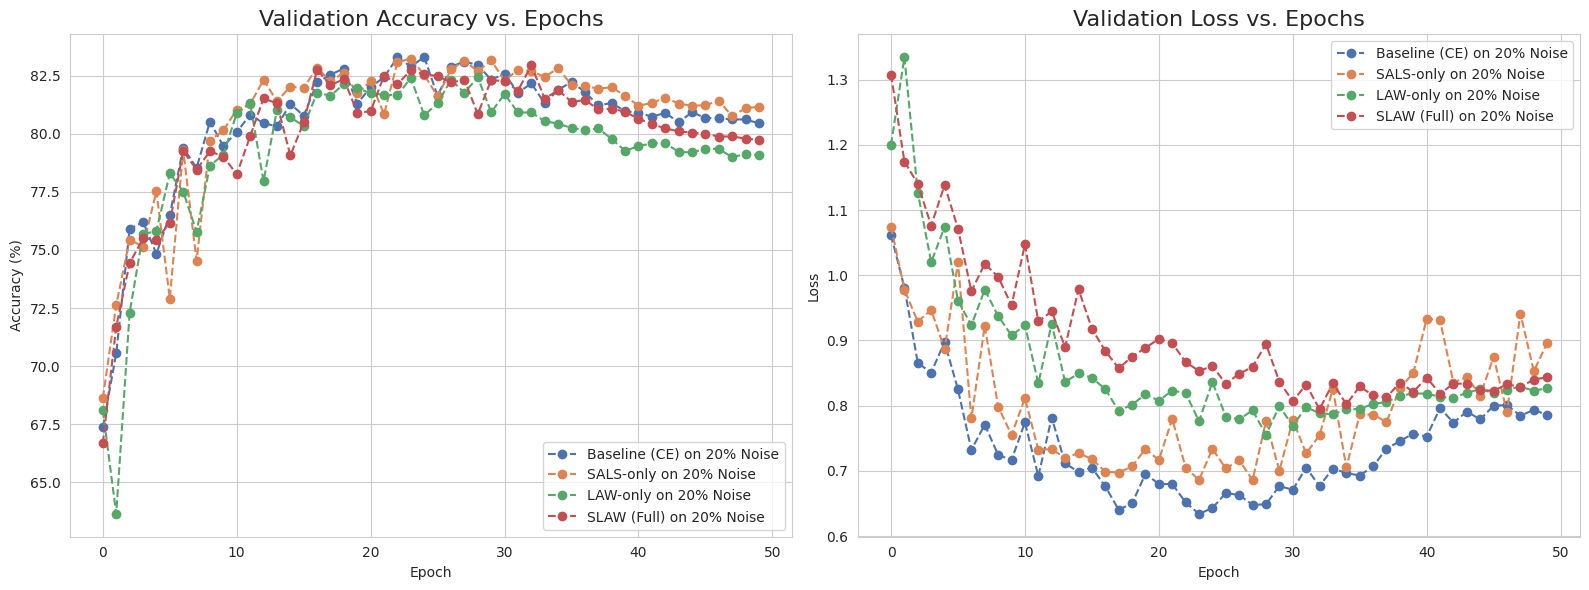

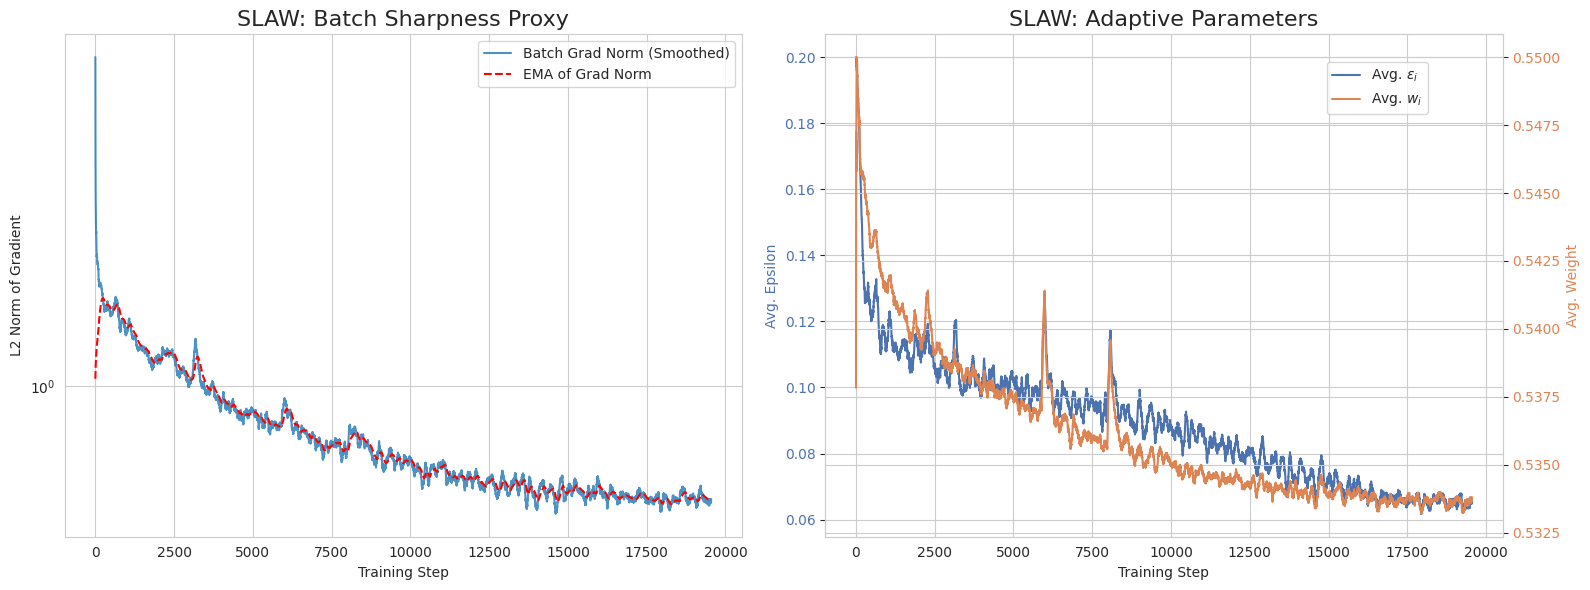

Analysis complete.


In [ ]:
# same like above expirement ... using the cloned version is recommended